<a href="https://colab.research.google.com/github/mohammadabid-macad/DesignGrammar_MA_SM_IAAC/blob/main/DesignGrammar_SelfSupervised_Hybrid__Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pickle
import os

# Mount the Google Drive
drive.mount('/content/drive')

# Define the base path where the saved data is stored
base_data_path = "/content/drive/MyDrive/BrickLayerX_2000/"


Mounted at /content/drive


In [ ]:
#!pip uninstall -y torch torchaudio torchvision dgl


In [ ]:
# Install PyTorch 1.13.1 and related libraries (CPU version)
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 --index-url https://download.pytorch.org/whl/cpu

# Install DGL 1.1.3 (CPU version, compatible with PyTorch 1.13.1)
!pip install dgl==1.1.3


Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 116.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0+cu121
    Uninstalling torch-2.4.0+cu121:
      Successfully uninstalled torch-2.4.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.19.0+cu121
    Uninstalling torchvision-0.19.0+cu121:
      Successfully uninstalled torchvision-0.19.0+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.4.0+cu121
    Uninstalling torchaudio-2.4.0+cu121:
      Successfully uninstalled torchaudio-2.4.0+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 12.6 MB/s eta 0:00:00


# Step 1: Loading Data

## 1.1 Loading DGL Graphs and Features

In [ ]:
import pickle
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path for DGL graphs
dgl_graphs_path = os.path.join(base_data_path, 'DGLGraphs/')

# Load patterns dataset (metadata like iteration ID)
with open(os.path.join(base_data_path, 'patterns_dataset.pkl'), 'rb') as f:
    patterns_dataset = pickle.load(f)

# Load all pattern DGL graphs from the subfolder
with open(os.path.join(dgl_graphs_path, 'all_pattern_dgl_graphs.pkl'), 'rb') as f:
    all_pattern_dgl_graphs = pickle.load(f)

# Load the empty grid DGL graph from the base folder
with open(os.path.join(base_data_path, 'empty_grid_dgl_graph.pkl'), 'rb') as f:
    empty_grid_dgl_graph = pickle.load(f)

# Load the combined normalized features (from step 5.3)
with open(os.path.join(base_data_path, 'combined_normalized_features.pkl'), 'rb') as f:
    combined_normalized_features = pickle.load(f)

# Extract node, edge, subgraph, and graph features
combined_node_features = combined_normalized_features['node_features']
combined_edge_features = combined_normalized_features['edge_features']
combined_subgraph_features = combined_normalized_features['subgraph_features']
combined_graph_features = combined_normalized_features['graph_features']

print("Data loading complete.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
Data loading complete.


## 1.2: Expanding Datsets of Different Levels

In [ ]:
# Function to print a sample row and data types for each feature set
def print_sample_row_and_dtypes(feature_set, feature_name):
    """
    Prints a sample row and the data types of each column for a given feature set.
    :param feature_set: The feature set DataFrame.
    :param feature_name: Name of the feature set (for display purposes).
    """
    print(f"\n--- {feature_name} ---")
    print("Sample Row:")
    print(feature_set.iloc[0])  # Print the first row as a sample
    print("\nData Types:")
    print(feature_set.dtypes)  # Print the data types of each column

# Assuming combined_normalized_features contains the normalized data sets

# Print for node features
print_sample_row_and_dtypes(combined_node_features[0], "Node Features")

# Print for edge features
print_sample_row_and_dtypes(combined_edge_features[0], "Edge Features")

# Print for subgraph features
print_sample_row_and_dtypes(combined_subgraph_features[0], "Subgraph Features")

# Print for graph features
print_sample_row_and_dtypes(combined_graph_features[0], "Graph Features")



--- Node Features ---
Sample Row:
node_id                                 0
brick_type                [0, 0, 1, 0, 0]
x_pos                                 0.0
y_pos                                 0.0
orientation                        [1, 0]
occupied                                1
insertion_point                         0
filler_module                           0
eigenvector_centrality             0.0008
Name: 0, dtype: object

Data Types:
node_id                     int64
brick_type                 object
x_pos                     float64
y_pos                     float64
orientation                object
occupied                    int64
insertion_point             int64
filler_module               int64
eigenvector_centrality    float64
dtype: object

--- Edge Features ---
Sample Row:
node_u               0
node_v               1
connectivity         1
orientation_match    1
Name: 0, dtype: int64

Data Types:
node_u               int64
node_v               int64
connectivity   

## 1.3 Adding Primary_brick to Node Features

In [ ]:
import pandas as pd  # Ensure pandas is imported
# Cell 1.3: Adding Primary_brick to Node Features Using Index-Based Comparison

# Step 1: Function to convert the primary brick type dictionary to an index (0-4)
def get_primary_brick_index(primary_brick_type_series):
    """Convert primary brick type dictionary to an index (0-4) and handle potential format issues."""
    brick_type_to_index = {'2x4': 0, '1x1': 1, '1x2': 2, '1x3': 3, '1x4': 4}

    # Extract the actual dictionary from the Pandas Series
    primary_brick_type_dict = primary_brick_type_series.iloc[0] if isinstance(primary_brick_type_series, pd.Series) else primary_brick_type_series

#    print(f"Primary brick type dictionary: {primary_brick_type_dict}")  # Debugging print

    # Loop through the dictionary and find the brick type with value 1
    for brick_type, value in primary_brick_type_dict.items():
        if value == 1:
            index = brick_type_to_index.get(brick_type, -1)  # Get index, return -1 if not found
           # print(f"Found primary brick type: {brick_type} with index {index}")  # Debugging print
            return index
    return -1  # Return -1 if no primary brick type is found

# Step 2: Function to add primary_brick column to the node features based on the index
def assign_primary_brick_with_index(combined_node_features, combined_graph_features):
    """
    Add a primary_brick column to combined_node_features for each graph based on the graph-level primary_brick_type.
    """
    for pattern_id in combined_node_features.keys():
        node_features_df = combined_node_features[pattern_id]
        graph_features_df = combined_graph_features[pattern_id]

        # Extract the primary brick type dictionary from graph features
        primary_brick_type_series = graph_features_df['primary_brick_type']

        # Convert the primary brick type dictionary to an index
        primary_brick_index = get_primary_brick_index(primary_brick_type_series)

        # If valid primary brick index is found (i.e., not -1)
        if primary_brick_index != -1:
            # Mark nodes where the brick_type matches the primary_brick_index
            def is_primary_brick(node_brick_type):
                return 1 if node_brick_type[primary_brick_index] == 1 else 0

            # Apply the primary brick logic to each node's brick type in the current pattern
            node_features_df['primary_brick'] = node_features_df['brick_type'].apply(is_primary_brick)

            # Update combined_node_features with the new column
            combined_node_features[pattern_id] = node_features_df

    return combined_node_features

# Call the function to update all graphs with the primary_brick column using indexing
combined_node_features = assign_primary_brick_with_index(combined_node_features, combined_graph_features)

# Verify that the primary_brick column has been added for Pattern ID 0
print("Sample node features with primary_brick column for Pattern ID 0:")
print(combined_node_features[0].head())

# Check the primary brick type for Pattern ID 0
primary_brick_type_series = combined_graph_features[0]['primary_brick_type']
primary_brick_index = get_primary_brick_index(primary_brick_type_series)

print(f"Primary brick type for Pattern ID 0 (from graph-level features): {primary_brick_type_series}")
print(f"Primary brick type index (for comparison): {primary_brick_index}")

# Count the nodes with primary_brick = 1 for Pattern ID 0
primary_brick_count = combined_node_features[0]['primary_brick'].sum()
print(f"Total number of primary brick nodes for Pattern ID 0: {primary_brick_count}")

# Print the indices of nodes with primary_brick = 1 for Pattern ID 0
primary_brick_node_indices = combined_node_features[0].index[combined_node_features[0]['primary_brick'] == 1].tolist()
print(f"Indices of primary brick nodes for Pattern ID 0: {primary_brick_node_indices}")


Sample node features with primary_brick column for Pattern ID 0:
   node_id       brick_type     x_pos  y_pos orientation  occupied  \
0        0  [0, 0, 1, 0, 0]  0.000000    0.0      [1, 0]         1   
1        1  [0, 0, 0, 1, 0]  0.020408    0.0      [1, 0]         1   
2        2  [0, 0, 1, 0, 0]  0.040816    0.0      [1, 0]         1   
3        3  [0, 0, 0, 1, 0]  0.061224    0.0      [1, 0]         1   
4        4  [0, 0, 0, 1, 0]  0.081633    0.0      [1, 0]         1   

   insertion_point  filler_module  eigenvector_centrality  primary_brick  
0                0              0                  0.0008              0  
1                0              0                  0.0012              0  
2                0              0                  0.0012              0  
3                0              0                  0.0012              0  
4                0              0                  0.0012              0  
Primary brick type for Pattern ID 0 (from graph-level features):

# Step 2: Embedding Features

Here's the outline for Step 2:

    Embed Node-Level Features: We will embed features such as brick type, position (x, y), orientation, occupied status, insertion point, filler module, and eigenvector centrality.

    Edge-Level Features: These features include edge connectivity and orientation match, which will be used during the neighborhood aggregation in the model.

    Graph-Level and Subgraph-Level Features: These will be handled later during pooling.

## 2.1 Embedding Node and Edge Features into the Pattern Graphs

In [ ]:
import pandas as pd
import torch
import numpy as np

# Function to embed node-level features into the DGL graph and return a DataFrame for pattern node features
def embed_node_features_in_dgl_graph(dgl_graph, node_features_df):
    """Embed node-level features from the dataframe into the DGL graph and create a DataFrame for pattern features."""

    # Scalar values
    x_pos = torch.tensor(node_features_df['x_pos'].values, dtype=torch.float32).unsqueeze(1)
    y_pos = torch.tensor(node_features_df['y_pos'].values, dtype=torch.float32).unsqueeze(1)
    eigenvector_centrality = torch.tensor(node_features_df['eigenvector_centrality'].values, dtype=torch.float32).unsqueeze(1)

    # Do not expand 'brick_type' and 'orientation' prematurely, they remain as list-like columns
    brick_type = torch.tensor(np.stack(node_features_df['brick_type'].values), dtype=torch.float32)
    orientation = torch.tensor(np.stack(node_features_df['orientation'].values), dtype=torch.float32)

    # Convert 'insertion_point', 'occupied', and 'filler_module' to float tensors
    insertion_point = torch.tensor(node_features_df['insertion_point'].values, dtype=torch.float32).unsqueeze(1)
    occupied = torch.tensor(node_features_df['occupied'].values, dtype=torch.float32).unsqueeze(1)
    filler_module = torch.tensor(node_features_df['filler_module'].values, dtype=torch.float32).unsqueeze(1)

    # Handle 'primary_brick' which remains as a scalar value (no need for expansion into multiple columns)
    primary_brick = torch.tensor(node_features_df['primary_brick'].values, dtype=torch.float32).unsqueeze(1)

    # Concatenate all node-level features into a matrix
    node_feature_matrix = torch.cat(
        [x_pos, y_pos, brick_type, orientation, occupied, insertion_point, primary_brick, filler_module, eigenvector_centrality], dim=1
    )

    # Assign the node features to the DGL graph
    dgl_graph.ndata['features'] = node_feature_matrix

    # Create a DataFrame for pattern node features for later use
    pattern_node_features_list = []

    for i in range(node_features_df.shape[0]):
        node_dict = {
            'x_pos': node_features_df['x_pos'].iloc[i],
            'y_pos': node_features_df['y_pos'].iloc[i],
            'eigenvector_centrality': node_features_df['eigenvector_centrality'].iloc[i],
            'brick_type': node_features_df['brick_type'].iloc[i],  # Keeping as list
            'orientation': node_features_df['orientation'].iloc[i],  # Keeping as list
            'occupied': node_features_df['occupied'].iloc[i],
            'insertion_point': node_features_df['insertion_point'].iloc[i],
            'primary_brick': node_features_df['primary_brick'].iloc[i],  # Keeping as scalar
            'filler_module': node_features_df['filler_module'].iloc[i]
        }
        pattern_node_features_list.append(node_dict)

    # Create DataFrame from the node features
    pattern_node_features_df = pd.DataFrame(pattern_node_features_list)

    return dgl_graph, pattern_node_features_df

# Initialize and print edge-level features
def initialize_edge_features(edge_features_df):
    """Convert edge-level features to tensor format."""
    connectivity = torch.tensor(edge_features_df['connectivity'].values, dtype=torch.float32).unsqueeze(1)
    orientation_match = torch.tensor(edge_features_df['orientation_match'].values, dtype=torch.float32).unsqueeze(1)

    # Concatenate edge-level features
    edge_feature_matrix = torch.cat([connectivity, orientation_match], dim=1)

    return edge_feature_matrix

# Initialize and print subgraph-level features
def initialize_subgraph_features(subgraph_features_df):
    """Convert subgraph-level features to tensor format."""

    # Convert 'brick_type' to one-hot encoding
    def convert_brick_type_to_one_hot(brick_type):
        brick_mapping = {'1x4': [1, 0, 0, 0, 0], '1x2': [0, 1, 0, 0, 0], '1x3': [0, 0, 1, 0, 0], '1x1': [0, 0, 0, 1, 0]}
        return brick_mapping.get(brick_type, [0, 0, 0, 0, 1])  # Default value

    brick_type_one_hot = np.array(subgraph_features_df['brick_type'].apply(convert_brick_type_to_one_hot).tolist(), dtype=np.float32)

    # Convert other columns to tensors
    num_cells = torch.tensor(subgraph_features_df['num_cells'].values, dtype=torch.float32).unsqueeze(1)
    orientation = torch.tensor(subgraph_features_df['orientation'].values, dtype=torch.float32).unsqueeze(1)
    completeness = torch.tensor(subgraph_features_df['completeness'].values, dtype=torch.float32).unsqueeze(1)

    # Concatenate subgraph-level features into a single matrix
    subgraph_feature_matrix = torch.cat([num_cells, orientation, completeness, torch.tensor(brick_type_one_hot)], dim=1)

    return subgraph_feature_matrix

# Initialize and print graph-level features
def initialize_graph_features(graph_features_df):
    """Convert graph-level features to tensor format."""
    available_pattern_space = torch.tensor(graph_features_df['available_pattern_space'].values, dtype=torch.float32).unsqueeze(1)
    completeness_score = torch.tensor(graph_features_df['completeness_score'].values, dtype=torch.float32).unsqueeze(1)
    modularity = torch.tensor(graph_features_df['modularity'].values, dtype=torch.float32).unsqueeze(1)
    selected_indices_count = torch.tensor(graph_features_df['selected_indices_count'].values, dtype=torch.float32).unsqueeze(1)

    # Concatenate graph-level features
    graph_feature_matrix = torch.cat([available_pattern_space, completeness_score, modularity, selected_indices_count], dim=1)

    return graph_feature_matrix

# Define node column names (for consistency during printing)
node_column_names = [
    'x_pos', 'y_pos',
    'brick_type',  # Keep brick_type as list
    'orientation',  # Keep orientation as list
    'occupied',
    'insertion_point',
    'primary_brick',  # Single column
    'filler_module', 'eigenvector_centrality'
]

# Loop through all pattern IDs to embed node, edge, subgraph, and graph-level features
for pattern_id, pattern_graph in all_pattern_dgl_graphs.items():
    node_features_df = combined_node_features[pattern_id]
    edge_features_df = combined_edge_features[pattern_id]
    subgraph_features_df = combined_subgraph_features[pattern_id]
    graph_features_df = combined_graph_features[pattern_id]

    # Embed node features for this graph and generate the pattern node DataFrame
    pattern_graph, pattern_node_features_df = embed_node_features_in_dgl_graph(pattern_graph, node_features_df)

    # Initialize edge, subgraph, and graph-level feature matrices
    edge_feature_matrix = initialize_edge_features(edge_features_df)
    subgraph_feature_matrix = initialize_subgraph_features(subgraph_features_df)
    graph_feature_matrix = initialize_graph_features(graph_features_df)

    # Print message or log progress
    print(f"Processed features for Pattern ID: {pattern_id}")

    # Optionally print sample outputs for the first pattern only
    if pattern_id == 0:
        print("Sample Embedded Node Features from First Pattern Graph (Pattern ID: 0):")
        embedded_node_features = pattern_graph.ndata['features'][0]  # First node's embedded features
        for name, value in zip(node_column_names, embedded_node_features.tolist()):
            print(f"{name}: {value}")

        print("\nSample Edge Features:")
        print(edge_feature_matrix[0])  # First edge's embedded features

        print("\nSample Subgraph Features:")
        print(subgraph_feature_matrix[0])  # First subgraph's embedded features

        print("\nSample Embedded Graph Features:")
        print(graph_feature_matrix[0])  # First graph's embedded features

        print("\nPattern Node Features DataFrame (first few rows):")
        print(pattern_node_features_df.head())


Processed features for Pattern ID: 0
Sample Embedded Node Features from First Pattern Graph (Pattern ID: 0):
x_pos: 0.0
y_pos: 0.0
brick_type: 0.0
orientation: 0.0
occupied: 1.0
insertion_point: 0.0
primary_brick: 0.0
filler_module: 1.0
eigenvector_centrality: 0.0

Sample Edge Features:
tensor([1., 1.])

Sample Subgraph Features:
tensor([0.4286, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000])

Sample Embedded Graph Features:
tensor([0.9062, 0.5942, 0.5964, 5.0000])

Pattern Node Features DataFrame (first few rows):
      x_pos  y_pos  eigenvector_centrality       brick_type orientation  \
0  0.000000    0.0                  0.0008  [0, 0, 1, 0, 0]      [1, 0]   
1  0.020408    0.0                  0.0012  [0, 0, 0, 1, 0]      [1, 0]   
2  0.040816    0.0                  0.0012  [0, 0, 1, 0, 0]      [1, 0]   
3  0.061224    0.0                  0.0012  [0, 0, 0, 1, 0]      [1, 0]   
4  0.081633    0.0                  0.0012  [0, 0, 0, 1, 0]      [1, 0]   

   occupied  insert

# Step 3: Create Partially Filled Nodes DataFrame


## 3.1: Generate Partially Filled Nodes DataFrame

This step creates a partially filled DataFrame (partially_filled_nodes_df) for each pattern by retaining information for primary_brick-positive nodes and clearing the values for primary_brick-negative nodes. The partially filled DataFrame is created without affecting the original pattern graph's DataFrame (pattern_node_features_df).

In [ ]:
import numpy as np
import pandas as pd

# 3.1: Create and Store Partially Filled Node Features for All Patterns
def create_partially_filled_node_features(pattern_node_features_df):
    """
    Create a new DataFrame for partially filled node features by clearing unnecessary data
    for non-primary-brick nodes while retaining key information like x_pos, y_pos, and eigenvector_centrality.
    """
    # Make a deep copy of the DataFrame to avoid altering the original pattern_node_features_df
    partially_filled_df = pattern_node_features_df.copy(deep=True)

    # Drop the node_id column as it should not be a feature
    if 'node_id' in partially_filled_df.columns:
        partially_filled_df = partially_filled_df.drop(columns=['node_id'])

    # Count primary brick positive rows (primary_brick == 1)
    primary_brick_positive_df = partially_filled_df[partially_filled_df['primary_brick'] == 1]
    primary_brick_positive_count = primary_brick_positive_df.shape[0]

    # Print count but display a randomly selected primary brick-positive row
    print(f"--- Found {primary_brick_positive_count} primary brick-positive nodes ---")
    print("--- A random primary brick-positive row ---")
    print(primary_brick_positive_df.sample(1))  # Randomly sample one row with a primary brick

    # Process only nodes that are NOT primary bricks
    non_primary_brick_mask = partially_filled_df['primary_brick'] == 0

    # Update non-primary-brick rows by setting NaN for fields that will be recalculated
    partially_filled_df.loc[non_primary_brick_mask, 'brick_type'] = np.nan
    partially_filled_df.loc[non_primary_brick_mask, 'orientation'] = np.nan
    partially_filled_df.loc[non_primary_brick_mask, 'occupied'] = np.nan
    partially_filled_df.loc[non_primary_brick_mask, 'filler_module'] = np.nan

    # Randomly sample one row of a non-primary-brick node (with cleared data)
    non_primary_brick_df = partially_filled_df[non_primary_brick_mask]
    print("--- A random primary brick-negative row (non-primary brick node with cleared data) ---")
    print(non_primary_brick_df.sample(1))

    # Retain eigenvector_centrality, x_pos, y_pos for all nodes
    return partially_filled_df


# Dictionary to store partially filled node features for all patterns
partially_filled_node_features = {}

# Process each pattern and store the partially filled node features in the dictionary
for pattern_id in combined_node_features.keys():
    pattern_node_features_df = combined_node_features[pattern_id]  # Fetch the full node features
    partially_filled_node_features_df = create_partially_filled_node_features(pattern_node_features_df)  # Create partially filled node features
    partially_filled_node_features[pattern_id] = partially_filled_node_features_df  # Store in dictionary

# Print some information for debugging
print(f"Partially Filled Node Features stored for {len(partially_filled_node_features)} patterns.")

# Debugging: Print the first few rows of the partially filled node features for pattern ID 0
pattern_id = 0  # Example pattern ID
print(f"--- Partially Filled Node Features for Pattern ID {pattern_id} ---")
print(partially_filled_node_features[pattern_id].head())


Streaming output truncated to the last 5000 lines.
--- A random primary brick-negative row (non-primary brick node with cleared data) ---
     brick_type     x_pos     y_pos orientation  occupied  insertion_point  \
1239        NaN  0.795918  0.489796         NaN       NaN                0   

      filler_module  eigenvector_centrality  primary_brick  
1239            NaN                0.001601              0  
--- Found 88 primary brick-positive nodes ---
--- A random primary brick-positive row ---
          brick_type     x_pos     y_pos orientation  occupied  \
456  [1, 0, 0, 0, 0]  0.122449  0.183673      [1, 0]         1   

     insertion_point  filler_module  eigenvector_centrality  primary_brick  
456                0              0                0.001601              1  
--- A random primary brick-negative row (non-primary brick node with cleared data) ---
     brick_type     x_pos     y_pos orientation  occupied  insertion_point  \
1657        NaN  0.142857  0.673469      

## Step 3.2: Embedding Partially Filled Node Features into DGL Graph

In [ ]:
import dgl
import torch

# Step 3.2: Embedding Features into Both Pattern and Partially Filled Graphs
def embed_features_in_both_graphs(pattern_graph, pattern_node_features_df, partially_filled_graph, partially_filled_node_features_df):
    """
    Embed features into both pattern and partially filled DGL graphs.

    Args:
        pattern_graph: The DGL graph of the original pattern.
        pattern_node_features_df: DataFrame containing node-level features for the pattern graph.
        partially_filled_graph: The DGL graph of the partially filled pattern.
        partially_filled_node_features_df: DataFrame containing node-level features for the partially filled graph.

    Returns:
        Tuple of (pattern_dgl_graph, partially_filled_dgl_graph) with features embedded.
    """
    # Embedding Node Features for Pattern Graph
    def embed_node_features(dgl_graph, node_features_df):
        """Embed node features from the dataframe into the DGL graph."""
        x_pos = torch.tensor(node_features_df['x_pos'].values, dtype=torch.float32).unsqueeze(1)
        y_pos = torch.tensor(node_features_df['y_pos'].values, dtype=torch.float32).unsqueeze(1)
        eigenvector_centrality = torch.tensor(node_features_df['eigenvector_centrality'].values, dtype=torch.float32).unsqueeze(1)

        # Handle NaN values for list columns like 'brick_type' and 'orientation'
        def fill_list_nan(row, default_size):
            if isinstance(row, list):
                return [0 if pd.isna(x) else x for x in row]
            return [0] * default_size  # Return a default list of zeros if it's not a list

        # Apply the fill function to brick_type (5 elements) and orientation (2 elements)
        brick_type = torch.tensor(node_features_df['brick_type'].apply(lambda x: fill_list_nan(x, 5)).tolist(), dtype=torch.float32)
        orientation = torch.tensor(node_features_df['orientation'].apply(lambda x: fill_list_nan(x, 2)).tolist(), dtype=torch.float32)

        primary_brick = torch.tensor(node_features_df['primary_brick'].values, dtype=torch.float32).unsqueeze(1)

        # Specifically handle NaNs for occupied and filler_module columns by filling them with 0
        occupied = torch.tensor(node_features_df['occupied'].fillna(0).values, dtype=torch.float32).unsqueeze(1)
        insertion_point = torch.tensor(node_features_df['insertion_point'].values, dtype=torch.float32).unsqueeze(1)
        filler_module = torch.tensor(node_features_df['filler_module'].fillna(0).values, dtype=torch.float32).unsqueeze(1)

        # Concatenate all features into a single matrix
        node_feature_matrix = torch.cat([
            x_pos, y_pos, eigenvector_centrality, brick_type, primary_brick,
            orientation, occupied, insertion_point, filler_module
        ], dim=1)

        # Assign node features to the DGL graph
        dgl_graph.ndata['features'] = node_feature_matrix
        return dgl_graph

    # Embed features into pattern graph
    pattern_dgl_graph = embed_node_features(pattern_graph, pattern_node_features_df)

    # Embed features into partially filled graph
    partially_filled_dgl_graph = embed_node_features(partially_filled_graph, partially_filled_node_features_df)

    return pattern_dgl_graph, partially_filled_dgl_graph


# Dictionary to store partially filled DGL graphs for all patterns
partially_filled_dgl_graphs = {}

# Loop through each pattern and embed features into both graphs
for pattern_id in combined_node_features.keys():
    pattern_graph = all_pattern_dgl_graphs[pattern_id]  # Load the pattern graph
    partially_filled_graph = pattern_graph.clone()  # Clone the pattern graph for partially filled version

    # Ensure that both pattern_node_features_df and partially_filled_node_features_df are available for this pattern ID
    pattern_node_features_df = combined_node_features[pattern_id]
    partially_filled_node_features_df = partially_filled_node_features[pattern_id]  # Use the output from Step 3.1

    # Call the function to embed features into both graphs
    pattern_dgl_graph, partially_filled_dgl_graph = embed_features_in_both_graphs(
        pattern_graph, pattern_node_features_df, partially_filled_graph, partially_filled_node_features_df
    )

    # Store the partially filled DGL graph for future use
    partially_filled_dgl_graphs[pattern_id] = partially_filled_dgl_graph

# Example: Print some information for debugging
print(f"Partially Filled DGL Graph - Number of Nodes: {partially_filled_dgl_graphs[0].num_nodes()}")
print(f"Partially Filled DGL Graph - Number of Edges: {partially_filled_dgl_graphs[0].num_edges()}")

# Column headings for the node features
columns = [
    'x_pos', 'y_pos', 'eigenvector_centrality', 'brick_type_1', 'brick_type_2', 'brick_type_3', 'brick_type_4', 'brick_type_5',
    'primary_brick', 'orientation_0', 'orientation_1', 'occupied', 'insertion_point', 'filler_module'
]

# Function to print a tensor with column headings
def print_tensor_with_columns(tensor, columns):
    row_data = tensor.numpy()
    print("\n".join([f"{col}: {val}" for col, val in zip(columns, row_data)]))

# Extract and print one row for pattern graph
print("\nOne row from Pattern Graph Node Features Tensor:")
print_tensor_with_columns(pattern_dgl_graph.ndata['features'][0], columns)

# Extract and print one row for primary_brick == 1 in partially filled graph
primary_brick_positive = (partially_filled_dgl_graph.ndata['features'][:, 7] == 1).nonzero(as_tuple=False)
if len(primary_brick_positive) > 0:
    print("\nOne primary brick-positive row from Partially Filled Graph Node Features Tensor:")
    print_tensor_with_columns(partially_filled_dgl_graph.ndata['features'][primary_brick_positive[0]], columns)

# Extract and print one row for primary_brick == 0 in partially filled graph
primary_brick_negative = (partially_filled_dgl_graph.ndata['features'][:, 7] == 0).nonzero(as_tuple=False)
if len(primary_brick_negative) > 0:
    print("\nOne primary brick-negative row from Partially Filled Graph Node Features Tensor:")
    print_tensor_with_columns(partially_filled_dgl_graph.ndata['features'][primary_brick_negative[0]], columns)


Partially Filled DGL Graph - Number of Nodes: 2500
Partially Filled DGL Graph - Number of Edges: 9800

One row from Pattern Graph Node Features Tensor:
x_pos: 0.0
y_pos: 0.0
eigenvector_centrality: 0.0008003201219253242
brick_type_1: 0.0
brick_type_2: 0.0
brick_type_3: 0.0
brick_type_4: 0.0
brick_type_5: 1.0
primary_brick: 0.0
orientation_0: 1.0
orientation_1: 0.0
occupied: 1.0
insertion_point: 0.0
filler_module: 0.0

One primary brick-negative row from Partially Filled Graph Node Features Tensor:
x_pos: [0.         0.         0.00080032 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [ ]:
import random

# Example: Print some information for debugging
print(f"Partially Filled DGL Graph - Number of Nodes: {partially_filled_dgl_graphs[0].num_nodes()}")
print(f"Partially Filled DGL Graph - Number of Edges: {partially_filled_dgl_graphs[0].num_edges()}")

# Define column names for clarity
columns = [
    'x_pos', 'y_pos', 'eigenvector_centrality', 'brick_type_1', 'brick_type_2',
    'brick_type_3', 'brick_type_4', 'brick_type_5', 'primary_brick',
    'orientation_0', 'orientation_1', 'occupied', 'insertion_point', 'filler_module'
]

# Get the tensor for partially filled graph
partially_filled_features = partially_filled_dgl_graphs[0].ndata['features']

# Find primary brick-positive and primary brick-negative rows
primary_brick_positive = partially_filled_features[partially_filled_features[:, 7] == 1.0]
primary_brick_negative = partially_filled_features[partially_filled_features[:, 7] == 0.0]

# Randomly select one row from each group
if len(primary_brick_positive) > 0:
    random_positive_index = random.randint(0, len(primary_brick_positive) - 1)
    positive_row = primary_brick_positive[random_positive_index]
    print("\nOne random primary brick-positive row from Partially Filled Graph Node Features Tensor (with column names):")
    for col, value in zip(columns, positive_row.tolist()):
        print(f"{col}: {value}")
else:
    print("No primary brick-positive row found.")

if len(primary_brick_negative) > 0:
    random_negative_index = random.randint(0, len(primary_brick_negative) - 1)
    negative_row = primary_brick_negative[random_negative_index]
    print("\nOne random primary brick-negative row from Partially Filled Graph Node Features Tensor (with column names):")
    for col, value in zip(columns, negative_row.tolist()):
        print(f"{col}: {value}")
else:
    print("No primary brick-negative row found.")


Partially Filled DGL Graph - Number of Nodes: 2500
Partially Filled DGL Graph - Number of Edges: 9800

One random primary brick-positive row from Partially Filled Graph Node Features Tensor (with column names):
x_pos: 0.6122449040412903
y_pos: 0.4285714328289032
eigenvector_centrality: 0.0016006402438506484
brick_type_1: 0.0
brick_type_2: 0.0
brick_type_3: 0.0
brick_type_4: 0.0
brick_type_5: 1.0
primary_brick: 1.0
orientation_0: 1.0
orientation_1: 0.0
occupied: 1.0
insertion_point: 0.0
filler_module: 0.0

One random primary brick-negative row from Partially Filled Graph Node Features Tensor (with column names):
x_pos: 0.12244898080825806
y_pos: 0.8367347121238708
eigenvector_centrality: 0.0016006402438506484
brick_type_1: 0.0
brick_type_2: 0.0
brick_type_3: 0.0
brick_type_4: 0.0
brick_type_5: 0.0
primary_brick: 0.0
orientation_0: 0.0
orientation_1: 0.0
occupied: 0.0
insertion_point: 0.0
filler_module: 0.0


# Step 4: Model Training Code

## 4.1 Define the Custom GraphSAGE Hybrid Model

Learning at Node, Edge, Subgraph, and Graph Levels:

    Node-Level: We use self.sage_node to perform node-level feature aggregation. Node embeddings are learned from node features.
    Edge-Level: We use self.edge_linear to transform the edge features. Edge information is passed into the node aggregation step through edge_weight=g.edata.get('transformed_edge_feats').
    Subgraph and Graph-Level: After the node-level feature aggregation, we pool node embeddings with dgl.mean_nodes() and further apply self.sage_graph to learn from the graph’s global structure. This enhances the node-level features with subgraph and graph-level knowledge.

Prediction at Node Level:

    The model only returns the node-level predictions (node_predictions), which predict the brick type for each node. The graph-level features help improve node predictions, but no graph-level or subgraph-level predictions are made.

In [ ]:
import torch
import torch.nn as nn
import dgl

# Custom GraphSAGE with learning at node, edge, subgraph, and graph levels, but prediction at node level
class HybridGraphSAGE(nn.Module):
    def __init__(self, in_feats_node, in_feats_edge, in_feats_subgraph, in_feats_graph, hidden_feats, out_feats_node):
        super(HybridGraphSAGE, self).__init__()

        # Node-level GraphSAGE for local feature aggregation
        self.sage_node = dgl.nn.SAGEConv(in_feats_node, hidden_feats, aggregator_type='mean')

        # Edge-level feature transformation layer
        self.edge_linear = nn.Linear(in_feats_edge, hidden_feats)

        # Subgraph-level feature transformation layer
        self.subgraph_linear = nn.Linear(in_feats_subgraph, hidden_feats)

        # Graph-level feature transformation layer
        self.graph_linear = nn.Linear(in_feats_graph, hidden_feats)

        # Linear layer for node-level predictions (brick type)
        self.node_linear = nn.Linear(hidden_feats, out_feats_node)

    def forward(self, g, features, edge_features, subgraph_features, graph_features):
        # Handle edge features
        print("Edge Features before transformation:")
        print(edge_features)  # Print to check for NaNs
        transformed_edge_feats = self.edge_linear(edge_features)  # Transform edge features
        g.edata['transformed_edge_feats'] = transformed_edge_feats  # Store transformed edge features

        # Node-level feature aggregation
        print("Node Features before GraphSAGE aggregation:")
        print(features)  # Print to check for NaNs
        node_embeddings = self.sage_node(g, features)

        # Handle subgraph-level features
        print("Subgraph Features before transformation:")
        print(subgraph_features)  # Print to check for NaNs
        transformed_subgraph_feats = self.subgraph_linear(subgraph_features)

        # Handle graph-level features
        print("Graph Features before transformation:")
        print(graph_features)  # Print to check for NaNs
        transformed_graph_feats = self.graph_linear(graph_features)

        # Combine all embeddings (node, subgraph, graph) for final aggregation
        g.ndata['h'] = node_embeddings + transformed_subgraph_feats + transformed_graph_feats

        # Pooling across nodes for graph-level learning (used for feature learning, not prediction)
        graph_embeddings = dgl.mean_nodes(g, 'h')

        # Node-level predictions (predicting brick type)
        node_predictions = self.node_linear(node_embeddings)

        print("Node Predictions after linear layer (before returning):")
        print(node_predictions)  # Print to check for NaNs

        return node_predictions  # Only return node-level predictions

# Example usage (with placeholders for inputs):
# Assuming in_feats_node, in_feats_edge, etc. are already defined
model = HybridGraphSAGE(in_feats_node=14, in_feats_edge=4, in_feats_subgraph=4, in_feats_graph=4, hidden_feats=128, out_feats_node=5)

# Run a dummy forward pass with diagnostic prints
# Placeholders for g, features, edge_features, subgraph_features, and graph_features
# These should be replaced by actual inputs from your data pipeline
g = dgl.graph(([0, 1], [1, 2]))  # Dummy graph for example
features = torch.randn((3, 14))  # Dummy node features (3 nodes, 14 features)
edge_features = torch.randn((2, 4))  # Dummy edge features (2 edges, 4 features)
subgraph_features = torch.randn((3, 4))  # Dummy subgraph features (3 nodes, 4 features)
graph_features = torch.randn((3, 4))  # Dummy graph features (3 nodes, 4 features)

# Run the model
output = model(g, features, edge_features, subgraph_features, graph_features)


Edge Features before transformation:
tensor([[ 1.0721,  0.1651, -1.9308,  0.7323],
        [ 0.1381,  0.3113,  1.4963,  1.5468]])
Node Features before GraphSAGE aggregation:
tensor([[ 1.4956, -0.0628, -0.4275,  0.2972,  0.1413, -0.0991, -0.2033, -0.2496,
          1.2973,  0.4956, -0.7161,  0.2282,  0.2321,  2.6816],
        [ 1.0248,  0.2247,  0.6229, -0.5990, -0.5835, -0.5670, -0.7538,  0.2977,
          0.6759, -0.5819,  2.1248,  1.2763, -1.2978,  0.2252],
        [ 0.4363,  0.5365, -0.3674, -0.7049,  0.4251,  0.3386,  1.7646,  0.3650,
         -0.7557,  1.7149, -0.9574,  1.7646,  1.8680,  1.1230]])
Subgraph Features before transformation:
tensor([[ 1.0550,  0.3171, -0.1191,  0.8872],
        [-1.3283,  0.2958,  0.5550, -0.3582],
        [-1.3712,  0.9877, -0.4872,  0.8880]])
Graph Features before transformation:
tensor([[ 1.3265,  2.0465, -1.5638,  0.3124],
        [ 0.7614, -0.9939,  0.5620,  2.1177],
        [-0.2571,  0.3988,  0.4740,  0.5047]])
Node Predictions after linear lay

## 4.2: Expanding brick_type

In [ ]:
import pandas as pd
import random

def expand_node_features(node_features_df):
    """
    Expand the brick_type and orientation columns, ensuring that all node features
    are in the correct format for the model. Exclude node_id from the final features.
    Additionally, for primary_brick == 0 nodes, ensure 'occupied' is set to 0.
    """

    # Exclude 'node_id' column if it exists
    if 'node_id' in node_features_df.columns:
        node_features_df = node_features_df.drop(columns=['node_id'])

    # Step 1: Expand the `brick_type` column (assumes brick_type is stored as a list of 5 elements)
    if 'brick_type' in node_features_df.columns:
        # Expand the `brick_type` column into separate columns
        brick_type_expanded = pd.DataFrame(node_features_df['brick_type'].tolist(),
                                           columns=['brick_type_1', 'brick_type_2', 'brick_type_3', 'brick_type_4', 'brick_type_5'])
        node_features_df = pd.concat([node_features_df, brick_type_expanded], axis=1)
        node_features_df.drop(columns=['brick_type'], inplace=True)  # Drop the original `brick_type` column

    # Step 2: Expand the `orientation` column into two scalar values (assumes orientation is a list of 2 elements)
    if 'orientation' in node_features_df.columns:
        orientation_expanded = pd.DataFrame(node_features_df['orientation'].tolist(),
                                            columns=['orientation_0', 'orientation_1'])
        node_features_df = pd.concat([node_features_df, orientation_expanded], axis=1)
        node_features_df.drop(columns=['orientation'], inplace=True)  # Drop the original `orientation` column

    # Step 3: Ensure that 'occupied' is set to 0 for primary_brick == 0
    node_features_df.loc[node_features_df['primary_brick'] == 0, 'occupied'] = 0

    return node_features_df

# Apply the function to all patterns' node features
expanded_node_features = {}

for pattern_id, node_features_df in combined_node_features.items():
    expanded_node_features[pattern_id] = expand_node_features(node_features_df)

print("Brick type and orientation columns have been expanded for all patterns.")

# Column names for expanded features
columns = [
    'x_pos', 'y_pos', 'eigenvector_centrality', 'brick_type_1', 'brick_type_2', 'brick_type_3', 'brick_type_4', 'brick_type_5',
    'primary_brick', 'orientation_0', 'orientation_1', 'occupied', 'insertion_point', 'filler_module'
]

# Function to print a random row from a DataFrame with column names
def print_random_row_with_columns(node_features_df, description):
    random_index = random.choice(node_features_df.index)
    print(f"\n--- {description} (Random Row {random_index}) ---")
    row_data = node_features_df.loc[random_index]
    for col in columns:
        print(f"{col}: {row_data[col]}")

# Debugging: Print random rows from the pattern graph, primary brick-positive, and primary brick-negative from partially filled graphs
pattern_id = 0  # Example pattern ID
expanded_df = expanded_node_features[pattern_id]

# Random row from pattern graph
print_random_row_with_columns(expanded_df, "Pattern Graph")

# Random row from primary brick-positive partially filled graph
positive_mask = expanded_df['primary_brick'] == 1
if positive_mask.any():
    print_random_row_with_columns(expanded_df[positive_mask], "Primary Brick-Positive Partially Filled Graph")

# Random row from primary brick-negative partially filled graph
negative_mask = expanded_df['primary_brick'] == 0
if negative_mask.any():
    print_random_row_with_columns(expanded_df[negative_mask], "Primary Brick-Negative Partially Filled Graph")


Brick type and orientation columns have been expanded for all patterns.

--- Pattern Graph (Random Row 488) ---
x_pos: 0.7755102040816326
y_pos: 0.18367346938775508
eigenvector_centrality: 0.001600640256102441
brick_type_1: 1.0
brick_type_2: 0.0
brick_type_3: 0.0
brick_type_4: 0.0
brick_type_5: 0.0
primary_brick: 0.0
orientation_0: 1.0
orientation_1: 0.0
occupied: 0.0
insertion_point: 0.0
filler_module: 0.0

--- Primary Brick-Positive Partially Filled Graph (Random Row 1435) ---
x_pos: 0.7142857142857142
y_pos: 0.5714285714285714
eigenvector_centrality: 0.001600640256102441
brick_type_1: 0.0
brick_type_2: 0.0
brick_type_3: 0.0
brick_type_4: 0.0
brick_type_5: 1.0
primary_brick: 1.0
orientation_0: 1.0
orientation_1: 0.0
occupied: 1.0
insertion_point: 0.0
filler_module: 0.0

--- Primary Brick-Negative Partially Filled Graph (Random Row 1463) ---
x_pos: 0.26530612244897955
y_pos: 0.5918367346938775
eigenvector_centrality: 0.001600640256102441
brick_type_1: 1.0
brick_type_2: 0.0
brick_type_

## 4.3: Defining Node-Level Labels for Training

extract the node labels (brick types) and graph labels (completeness, modularity) from our dataset.

In [ ]:
import numpy as np

def define_node_labels(expanded_node_features_df):
    """
    Extract the node-level labels (brick types) from the expanded node features.
    Assign 0 to primary_brick == 0 (primary brick-negative rows) to mark them as unlabeled.
    """
    # Check if 'brick_type_1' to 'brick_type_5' columns exist
    if all(col in expanded_node_features_df.columns for col in ['brick_type_1', 'brick_type_2', 'brick_type_3', 'brick_type_4', 'brick_type_5']):
        # Concatenate brick_type columns into a NumPy array for label generation
        brick_type_columns = ['brick_type_1', 'brick_type_2', 'brick_type_3', 'brick_type_4', 'brick_type_5']
        brick_type_labels = expanded_node_features_df[brick_type_columns].values

        # Convert the one-hot encoded labels into class indices (for training)
        class_indices = np.argmax(brick_type_labels, axis=1) + 1  # Convert to 1-5 (instead of 0-4)

        # For primary_brick == 0 rows (unlabeled data), set the class label to 0
        primary_brick_mask = expanded_node_features_df['primary_brick'] == 0
        class_indices[primary_brick_mask] = 0  # Mark unlabeled rows with 0

        return class_indices  # Return class index labels (for training)

    else:
        raise ValueError("Brick type columns not found in the expanded node features.")

# Generate node-level labels for each pattern graph
node_labels = {}

for pattern_id, expanded_node_features_df in expanded_node_features.items():
    node_labels[pattern_id] = define_node_labels(expanded_node_features_df)

print("Node-level labels (brick types) defined for all patterns.")

# Debugging: Print node labels for Pattern ID 0
print("Node Labels for Pattern ID 0 (first few):")
print(node_labels[0][:10])  # Print first 10 labels as a sample


Node-level labels (brick types) defined for all patterns.
Node Labels for Pattern ID 0 (first few):
[0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Function to check and print primary brick-positive and primary brick-negative rows
def print_primary_brick_patterns(expanded_node_features_df, node_labels, description):
    print(f"\n--- {description} ---")

    # Primary brick-positive (primary_brick == 1)
    positive_mask = expanded_node_features_df['primary_brick'] == 1
    if positive_mask.any():
        print("\nPrimary Brick-Positive Rows:")
        positive_indices = positive_mask[positive_mask].index
        for idx in positive_indices[:5]:  # Print up to 5 rows as sample
            print(f"Row {idx} - Brick Type: {node_labels[idx]}")

    # Primary brick-negative (primary_brick == 0)
    negative_mask = expanded_node_features_df['primary_brick'] == 0
    if negative_mask.any():
        print("\nPrimary Brick-Negative Rows:")
        negative_indices = negative_mask[negative_mask].index
        for idx in negative_indices[:5]:  # Print up to 5 rows as sample
            print(f"Row {idx} - Brick Type: {node_labels[idx]}")

# Select a pattern to diagnose (e.g., pattern_id 0)
pattern_id = 0

# Get the expanded node features and node labels for the selected pattern
expanded_df = expanded_node_features[pattern_id]
node_label_sample = node_labels[pattern_id]

# Print patterns for the primary brick-positive and primary brick-negative rows
print_primary_brick_patterns(expanded_df, node_label_sample, "Partially Filled Graph")

# For comparison, print node labels for the same pattern graph (the complete original graph)
print("\n--- Pattern Graph Node Labels (first few rows): ---")
for idx in range(10):  # Print the first 10 rows as a sample
    print(f"Row {idx} - Brick Type: {node_label_sample[idx]}")



--- Partially Filled Graph ---

Primary Brick-Positive Rows:
Row 1030 - Brick Type: 5
Row 1080 - Brick Type: 5
Row 1130 - Brick Type: 5
Row 1180 - Brick Type: 5
Row 1433 - Brick Type: 5

Primary Brick-Negative Rows:
Row 0 - Brick Type: 0
Row 1 - Brick Type: 0
Row 2 - Brick Type: 0
Row 3 - Brick Type: 0
Row 4 - Brick Type: 0

--- Pattern Graph Node Labels (first few rows): ---
Row 0 - Brick Type: 0
Row 1 - Brick Type: 0
Row 2 - Brick Type: 0
Row 3 - Brick Type: 0
Row 4 - Brick Type: 0
Row 5 - Brick Type: 0
Row 6 - Brick Type: 0
Row 7 - Brick Type: 0
Row 8 - Brick Type: 0
Row 9 - Brick Type: 0


## 4.4: Splitting Data into Training, Validation, and Test Sets

In [ ]:
import torch
from sklearn.model_selection import train_test_split

# Total number of patterns (graphs)
total_patterns = len(combined_graph_features)  # Assuming combined_graph_features has one entry per pattern

# Split into training (70%), validation (15%), and test (15%) at the pattern level
train_size = int(0.7 * total_patterns)  # 70% of total patterns
val_size = int(0.15 * total_patterns)  # 15% of total patterns
test_size = total_patterns - (train_size + val_size)  # Remaining patterns for testing

# Get pattern IDs (iteration IDs or graph IDs)
pattern_ids = list(combined_graph_features.keys())  # Assuming pattern IDs are the keys in combined_graph_features

# Split the patterns into training, validation, and test sets
train_patterns, val_test_patterns = train_test_split(pattern_ids, train_size=train_size, random_state=42)
val_patterns, test_patterns = train_test_split(val_test_patterns, train_size=val_size, random_state=42)

# Debugging: Print split sizes
print(f"Training Patterns: {len(train_patterns)}")  # Should be 70% of total patterns
print(f"Validation Patterns: {len(val_patterns)}")  # Should be 15% of total patterns
print(f"Test Patterns: {len(test_patterns)}")  # Should be 15% of total patterns

# Function to get the corresponding node features and graph-level features for each pattern
def get_data_for_patterns(pattern_ids):
    node_features = {pattern_id: combined_node_features[pattern_id] for pattern_id in pattern_ids}
    graph_features = {pattern_id: combined_graph_features[pattern_id] for pattern_id in pattern_ids}
    return node_features, graph_features

# Get the training, validation, and test data
train_node_features, train_graph_features = get_data_for_patterns(train_patterns)
val_node_features, val_graph_features = get_data_for_patterns(val_patterns)
test_node_features, test_graph_features = get_data_for_patterns(test_patterns)

# Create boolean masks for training, validation, and testing based on pattern index
train_mask = torch.zeros(total_patterns, dtype=torch.bool)
val_mask = torch.zeros(total_patterns, dtype=torch.bool)
test_mask = torch.zeros(total_patterns, dtype=torch.bool)

# Set the appropriate indices in the masks to True based on pattern IDs
train_mask[[pattern_ids.index(p) for p in train_patterns]] = True
val_mask[[pattern_ids.index(p) for p in val_patterns]] = True
test_mask[[pattern_ids.index(p) for p in test_patterns]] = True

# Debugging: Print graph partitioning and mask sums
print("---- Debugging: Graph Partitioning ----")
print(f"Total number of patterns: {len(pattern_ids)}")

# Print example pattern IDs for each set
print(f"\nTraining Patterns (70%): {len(train_patterns)}")
print(f"Sample Training Pattern IDs: {train_patterns[:5]}...")  # First 5 training IDs

print(f"\nValidation Patterns (15%): {len(val_patterns)}")
print(f"Sample Validation Pattern IDs: {val_patterns[:5]}...")  # First 5 validation IDs

print(f"\nTest Patterns (15%): {len(test_patterns)}")
print(f"Sample Test Pattern IDs: {test_patterns[:5]}...")  # First 5 test IDs

# Check mask sums
print(f"\nTrain Mask Sum: {train_mask.sum().item()} (Expected: {len(train_patterns)})")
print(f"Validation Mask Sum: {val_mask.sum().item()} (Expected: {len(val_patterns)})")
print(f"Test Mask Sum: {test_mask.sum().item()} (Expected: {len(test_patterns)})")


Training Patterns: 1400
Validation Patterns: 300
Test Patterns: 300
---- Debugging: Graph Partitioning ----
Total number of patterns: 2000

Training Patterns (70%): 1400
Sample Training Pattern IDs: [836, 575, 557, 1235, 1360]...

Validation Patterns (15%): 300
Sample Validation Pattern IDs: [49, 1389, 1861, 292, 1512]...

Test Patterns (15%): 300
Sample Test Pattern IDs: [771, 1788, 1106, 787, 785]...

Train Mask Sum: 1400 (Expected: 1400)
Validation Mask Sum: 300 (Expected: 300)
Test Mask Sum: 300 (Expected: 300)


## 4.5: Self-Supervised Learning on Partially Filled Graphs

In [ ]:
# Centralized hyperparameter container
hyperparams = {
    'in_feats': 14,       # Number of input features based on expanded brick_type and orientation
    'hidden_feats': 4,   # Number of hidden units in the SAGEConv layer
    'out_feats_node': 6,  # Number of classes for node-level classification (brick types) + 0 for unlabelled bricks
    'dropout_rate': 0.5,  # Dropout rate
    'learning_rate': 0.05,  # Learning rate for training
    'num_epochs': 30      # Number of epochs for training
}


In [ ]:
import torch
import torch.nn as nn
import dgl
import numpy as np
import pandas as pd

# Define the Hybrid GraphSAGE model using the hyperparameters from the container
class HybridGraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats_node, dropout_rate):
        super(HybridGraphSAGE, self).__init__()

        # Node-level GraphSAGE for local feature aggregation
        self.sage_node = dgl.nn.SAGEConv(in_feats, hidden_feats, aggregator_type='mean')

        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=dropout_rate)

        # Linear layer for node-level predictions (brick type)
        self.node_linear = nn.Linear(hidden_feats, out_feats_node)

    def forward(self, g, features):
        # Node-level aggregation and predictions with dropout
        node_embeddings = self.sage_node(g, features)
        node_embeddings = self.dropout(node_embeddings)  # Apply dropout to node embeddings
        node_predictions = self.node_linear(node_embeddings)

        return node_predictions

# Define the model using hyperparameters
model = HybridGraphSAGE(
    hyperparams['in_feats'],
    hyperparams['hidden_feats'],
    hyperparams['out_feats_node'],
    hyperparams['dropout_rate']
)

# Function to prepare node features, expanding brick_type and collapsing orientation
def prepare_node_features(node_features_df):
    """Flatten list-like columns and ensure all node features are numerical (float)."""
    if 'node_id' in node_features_df.columns:
        node_features_df = node_features_df.drop(columns=['node_id'])  # Drop node_id if exists

    # Ensure all columns are float or int (convert if needed)
    for col in node_features_df.columns:
        if node_features_df[col].dtype == 'object':
            node_features_df[col] = node_features_df[col].astype(float)

    return node_features_df

# Training function for the Hybrid GraphSAGE model
def train_hybrid_graphsage(model, graphs, node_features, node_labels, train_mask, val_mask, hyperparams):
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # Use ignore_index=0 to ignore unlabeled nodes during training

    epoch_losses = []  # Store training losses
    val_losses = []  # Store validation losses
    val_accuracies = []  # Store validation accuracies

    for epoch in range(hyperparams['num_epochs']):
        model.train()  # Set model to training mode
        epoch_loss = 0  # Reset epoch loss

        for graph_id, dgl_graph in graphs.items():
            # Prepare node features
            node_feats_df = prepare_node_features(node_features[graph_id])
            node_feats = torch.tensor(node_feats_df.values, dtype=torch.float32)

            # Get node labels and convert them to PyTorch tensor
            node_labels_tensor = torch.tensor(node_labels[graph_id], dtype=torch.long)

            # Forward pass through the model
            node_preds = model(dgl_graph, node_feats)

            # Check if this graph is part of the training set
            if train_mask[pattern_ids.index(graph_id)]:
                # Compute the loss, ignoring primary bricks (label == 0)
                node_loss = loss_fn(node_preds, node_labels_tensor)

                # Backpropagation
                optimizer.zero_grad()
                node_loss.backward()
                optimizer.step()

                epoch_loss += node_loss.item()

        epoch_losses.append(epoch_loss / len(graphs))
        print(f"Epoch {epoch + 1}/{hyperparams['num_epochs']}, Loss: {epoch_loss / len(graphs)}")

        # Validation step
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        val_correct = 0  # For accuracy
        val_total = 0  # For accuracy

        with torch.no_grad():
            for graph_id, dgl_graph in graphs.items():
                if val_mask[pattern_ids.index(graph_id)]:
                    node_feats_df = prepare_node_features(node_features[graph_id])
                    node_feats = torch.tensor(node_feats_df.values, dtype=torch.float32)
                    node_labels_tensor = torch.tensor(node_labels[graph_id], dtype=torch.long)

                    # Forward pass for validation
                    node_preds = model(dgl_graph, node_feats)

                    # Calculate validation accuracy (excluding primary bricks)
                    mask = node_labels_tensor != 0  # Only consider non-primary bricks for accuracy
                    val_total += mask.sum().item()  # Count only non-primary bricks
                    val_correct += (node_preds.argmax(dim=1)[mask] == node_labels_tensor[mask]).sum().item()

                    # Calculate validation loss, ignoring primary bricks
                    val_loss += loss_fn(node_preds, node_labels_tensor).item()

        val_accuracy = val_correct / val_total if val_total > 0 else 0  # Calculate validation accuracy
        val_losses.append(val_loss / len(graphs))
        val_accuracies.append(val_accuracy)  # Append validation accuracy
        print(f"Validation Loss: {val_loss / len(graphs)}, Validation Accuracy: {val_accuracy}")

    return epoch_losses, val_losses, val_accuracies

# Train the model using the hyperparameters
epoch_losses, val_losses, val_accuracies = train_hybrid_graphsage(
    model,
    all_pattern_dgl_graphs,
    expanded_node_features,  # Using expanded node features
    node_labels,
    train_mask,  # Pass train_mask here
    val_mask,  # Pass val_mask here
    hyperparams  # Pass the centralized hyperparameters
)


Epoch 1/30, Loss: 0.26578074221429415
Validation Loss: 0.0008345357220459846, Validation Accuracy: 1.0
Epoch 2/30, Loss: 0.21167811125650768
Validation Loss: 0.0003436388479415449, Validation Accuracy: 1.0
Epoch 3/30, Loss: 0.20374455964486515
Validation Loss: 0.00012542059295810758, Validation Accuracy: 1.0
Epoch 4/30, Loss: 0.21875249008024003
Validation Loss: 8.746663166675717e-06, Validation Accuracy: 1.0
Epoch 5/30, Loss: 0.20059538736325339
Validation Loss: 0.0, Validation Accuracy: 1.0
Epoch 6/30, Loss: 0.2070490635772221
Validation Loss: 0.0, Validation Accuracy: 1.0
Epoch 7/30, Loss: 0.2338697688721004
Validation Loss: 0.0, Validation Accuracy: 1.0
Epoch 8/30, Loss: 0.1846817719617835
Validation Loss: 0.0, Validation Accuracy: 1.0
Epoch 9/30, Loss: 0.2377048556310365
Validation Loss: 0.0, Validation Accuracy: 1.0
Epoch 10/30, Loss: 0.2361583891480087
Validation Loss: 2.0430499489521025e-08, Validation Accuracy: 1.0
Epoch 11/30, Loss: 0.18394045270922652
Validation Loss: 0.0, V

## 4.6: Plot Training and Validation Loss, and Validation Accuracy

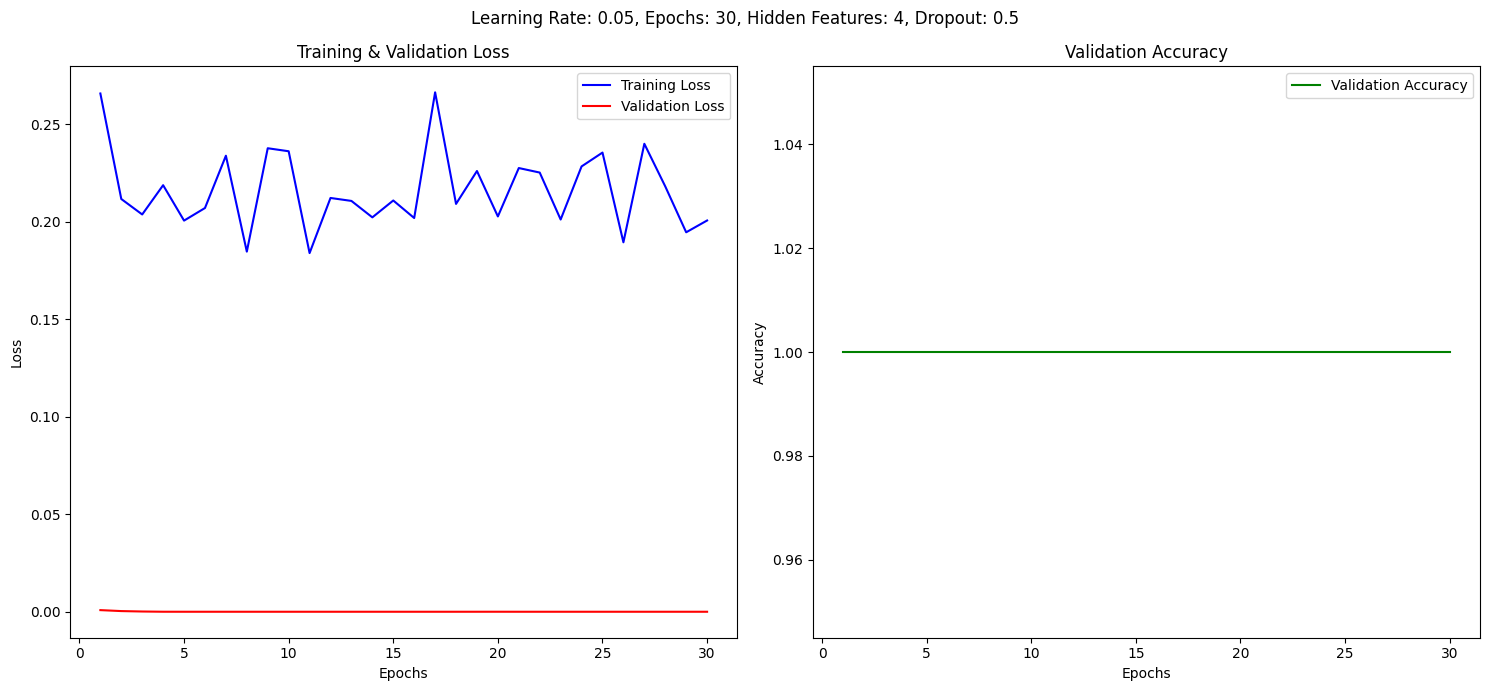

Training and validation metrics plot saved to /content/drive/MyDrive/Model Testing/0036/training_validation_plot.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to create incremental folders
def create_incremental_folder(base_dir):
    folder_num = 1
    while os.path.exists(os.path.join(base_dir, f"{folder_num:04d}")):
        folder_num += 1
    new_folder = os.path.join(base_dir, f"{folder_num:04d}")
    os.makedirs(new_folder)
    return new_folder

# Function to plot training and validation metrics and save to incremental folder
def plot_training_validation(epoch_losses, val_losses, val_accuracies, hyperparams, base_dir):
    """Plot training and validation losses and accuracies across epochs, and save the plot."""
    epochs = range(1, len(epoch_losses) + 1)

    # Extract hyperparameters from the container
    lr = hyperparams['learning_rate']
    num_epochs = hyperparams['num_epochs']
    hidden_feats = hyperparams['hidden_feats']
    dropout = hyperparams['dropout_rate']

    # Create an incremental folder in the base directory
    save_dir = create_incremental_folder(base_dir)

    # Create a figure with subplots for Losses and Accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Plot Training and Validation Loss on the first subplot
    ax1.plot(epochs, epoch_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training & Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot Validation Accuracy on the second subplot
    ax2.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Add hyperparameters to the plot title for clarity
    fig.suptitle(f"Learning Rate: {lr}, Epochs: {num_epochs}, Hidden Features: {hidden_feats}, Dropout: {dropout}")

    # Adjust layout for better viewing
    plt.tight_layout()

    # Save plot to the created incremental folder
    plot_filename = os.path.join(save_dir, "training_validation_plot.png")
    plt.savefig(plot_filename)
    plt.show()

    print(f"Training and validation metrics plot saved to {plot_filename}")
    return save_dir  # Return the folder path to use in Step 4.7

# Call the plot function using the hyperparameters container
base_directory = '/content/drive/MyDrive/Model Testing'  # Base directory where the incremental folder will be created
save_directory_4_6 = plot_training_validation(
    epoch_losses,   # From training function
    val_losses,     # From validation step
    val_accuracies, # Validation accuracy recorded during training
    hyperparams,    # Automatically pass hyperparameters from container
    base_directory  # Base directory for saving plots
)


## 4.7: Visualize Model Results on Random Test Patterns

In [ ]:
import torch
import random

# Function to convert one-hot encoded brick_type to label (1-5)
def one_hot_to_label(one_hot_array):
    return np.argmax(one_hot_array) + 1  # Convert one-hot array to label (1-5)

# Function to compare ground truth and predicted brick types for a random test graph
def compare_ground_truth_vs_prediction(model, test_graphs, test_node_features, pattern_node_features):
    # Pick a random graph from the test set
    random_graph_id = random.choice(test_patterns)

    print(f"\n--- Comparing Ground Truth vs Predictions for Pattern ID {random_graph_id} ---\n")

    # Get the DGL graph and node features for the selected pattern
    test_graph = test_graphs[random_graph_id]
    test_node_feats_df = test_node_features[random_graph_id]  # Partially filled graph
    pattern_node_feats_df = pattern_node_features[random_graph_id]  # Fully labelled ground truth (pattern graph)

    # Prepare node features for prediction
    node_feats = torch.tensor(test_graph.ndata['features'], dtype=torch.float32)

    # Predict brick types using the model
    model.eval()
    with torch.no_grad():
        predictions = model(test_graph, node_feats).argmax(dim=1).numpy()

    # Extract ground truth brick types (convert one-hot to label 1-5)
    ground_truth_labels = pattern_node_feats_df['brick_type'].apply(one_hot_to_label).values

    # Print ground truth vs predicted brick types for each node
    print(f"{'Node ID':<10}{'Ground Truth':<15}{'Predicted':<10}")
    print('-' * 35)
    for i in range(len(ground_truth_labels)):
        print(f"{i:<10}{ground_truth_labels[i]:<15}{predictions[i]:<10}")

# Run the comparison for a random pattern in the test set
compare_ground_truth_vs_prediction(
    model,
    partially_filled_dgl_graphs,  # Test set DGL graphs
    partially_filled_node_features,  # Node features of the test set (partially filled graphs)
    combined_node_features  # Ground truth node features (fully labelled pattern graph)
)



--- Comparing Ground Truth vs Predictions for Pattern ID 1832 ---

Node ID   Ground Truth   Predicted 
-----------------------------------
0         5              4         
1         5              4         
2         5              4         
3         5              4         
4         4              4         
5         4              4         
6         4              4         
7         5              4         
8         5              4         
9         5              4         
10        5              4         
11        3              4         
12        4              4         
13        4              4         
14        4              4         
15        5              4         
16        5              4         
17        5              4         
18        5              4         
19        3              4         
20        3              4         
21        2              4         
22        5              4         
23        5              4      

<ipython-input-21-a96e64f6bfd1>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_feats = torch.tensor(test_graph.ndata['features'], dtype=torch.float32)



1007      2              4         
1008      5              4         
1009      5              4         
1010      5              4         
1011      4              4         
1012      5              4         
1013      4              4         
1014      5              4         
1015      3              4         
1016      5              4         
1017      5              4         
1018      5              4         
1019      5              4         
1020      2              4         
1021      3              4         
1022      3              4         
1023      4              4         
1024      5              4         
1025      3              4         
1026      5              4         
1027      5              4         
1028      3              4         
1029      5              4         
1030      5              4         
1031      5              4         
1032      5              4         
1033      5              4         
1034      4              4 


--- Sample Data for Partially Filled Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           0
1  0.020408    0.0           0
2  0.040816    0.0           0
3  0.061224    0.0           0
4  0.081633    0.0           0

--- Sample Predicted Data ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           5
1  0.020408    0.0           3
2  0.040816    0.0           3
3  0.061224    0.0           3
4  0.081633    0.0           3

--- Sample Data for Ground Truth Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           3
1  0.020408    0.0           4
2  0.040816    0.0           4
3  0.061224    0.0           4
4  0.081633    0.0           4


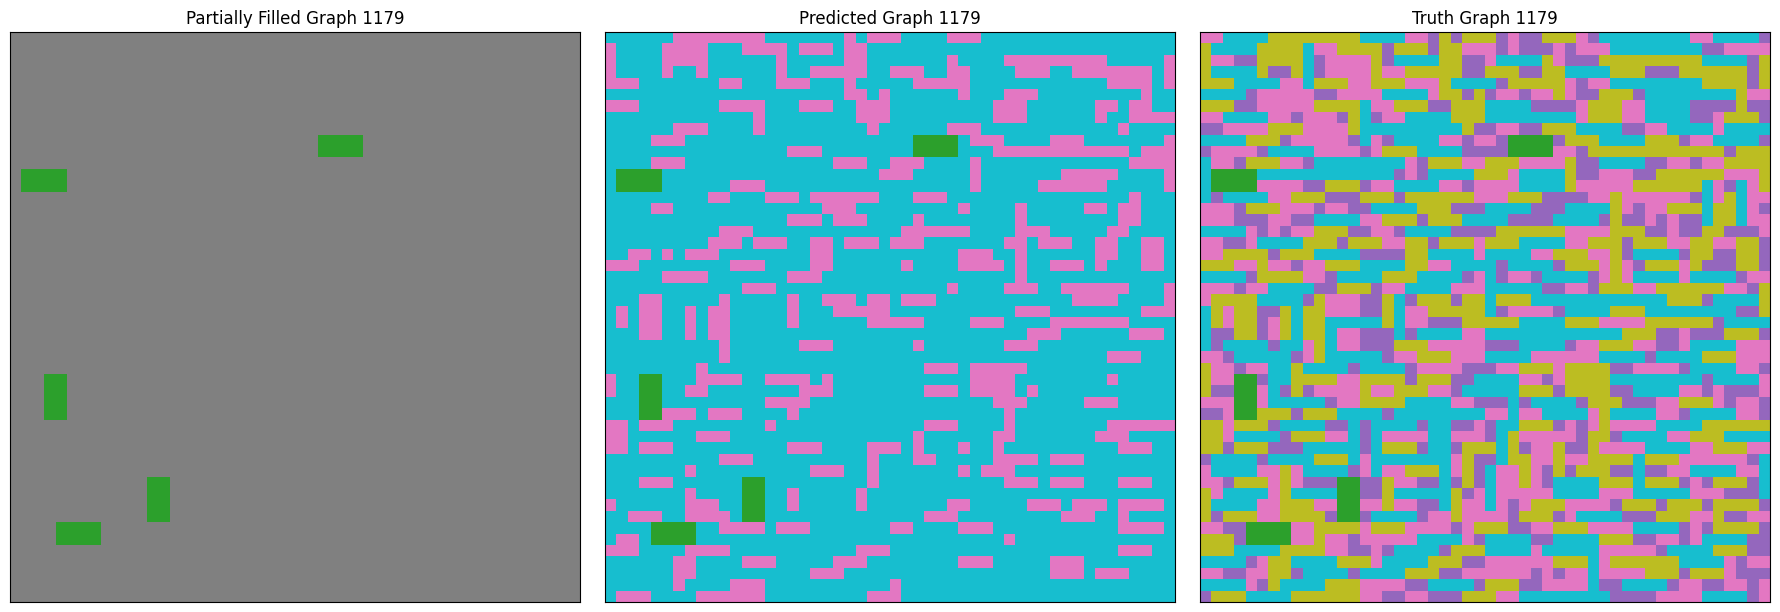

Visualization saved to /content/drive/MyDrive/Model Testing/0036/Graph_1179/visualization_Graph_1179.png

--- Sample Data for Partially Filled Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           0
1  0.020408    0.0           0
2  0.040816    0.0           0
3  0.061224    0.0           0
4  0.081633    0.0           0

--- Sample Predicted Data ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           5
1  0.020408    0.0           5
2  0.040816    0.0           3
3  0.061224    0.0           3
4  0.081633    0.0           3

--- Sample Data for Ground Truth Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           3
1  0.020408    0.0           3
2  0.040816    0.0           4
3  0.061224    0.0           4
4  0.081633    0.0           4


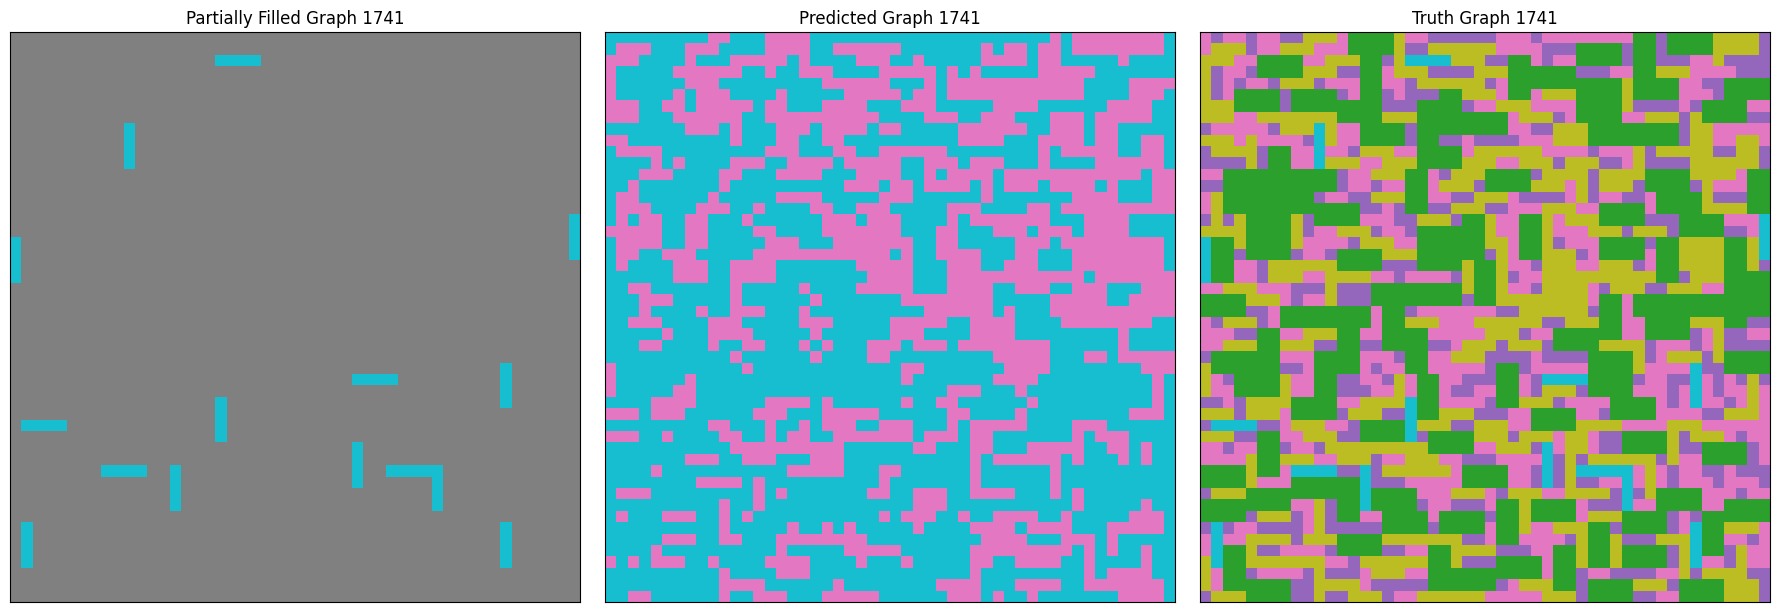

Visualization saved to /content/drive/MyDrive/Model Testing/0036/Graph_1741/visualization_Graph_1741.png

--- Sample Data for Partially Filled Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           0
1  0.020408    0.0           0
2  0.040816    0.0           0
3  0.061224    0.0           0
4  0.081633    0.0           0

--- Sample Predicted Data ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           5
1  0.020408    0.0           5
2  0.040816    0.0           5
3  0.061224    0.0           5
4  0.081633    0.0           5

--- Sample Data for Ground Truth Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           5
1  0.020408    0.0           5
2  0.040816    0.0           5
3  0.061224    0.0           5
4  0.081633    0.0           3


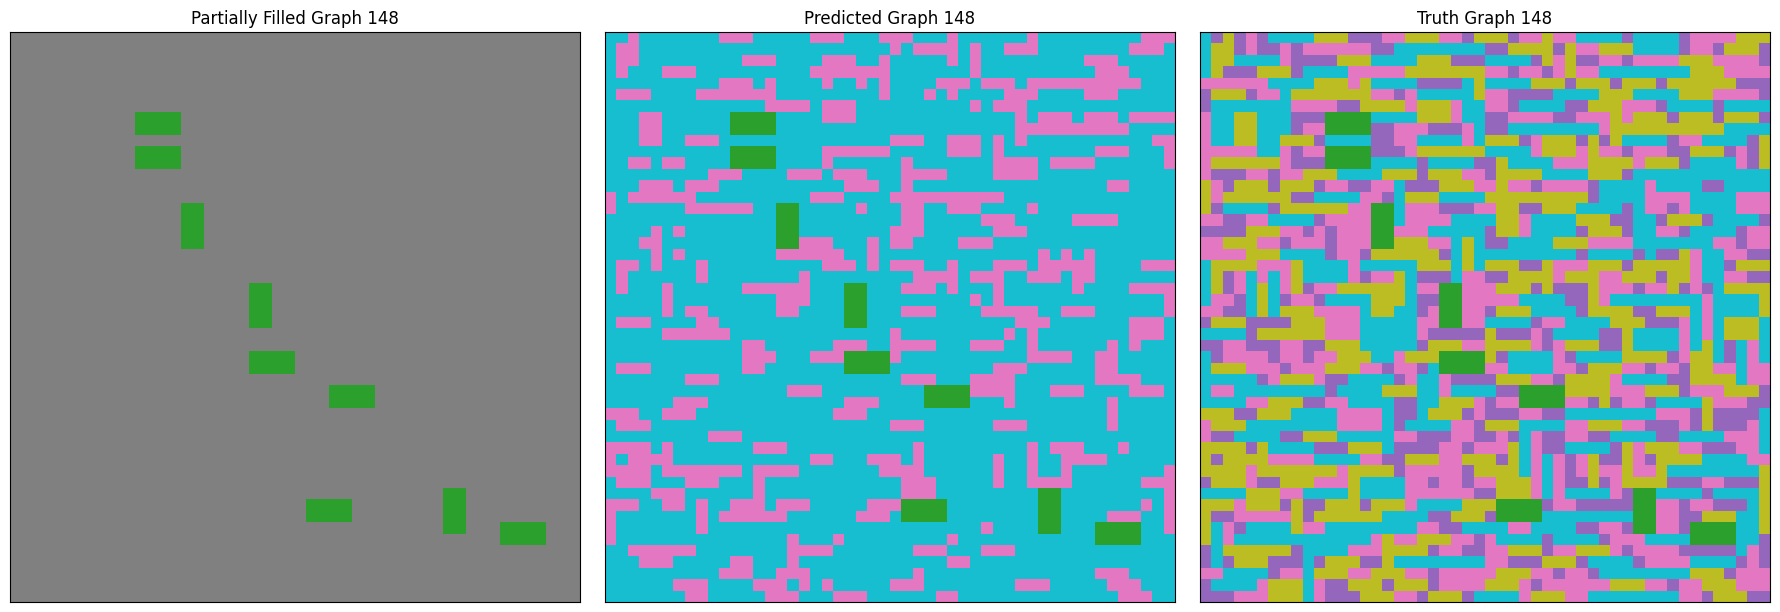

Visualization saved to /content/drive/MyDrive/Model Testing/0036/Graph_148/visualization_Graph_148.png

--- Sample Data for Partially Filled Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           0
1  0.020408    0.0           0
2  0.040816    0.0           0
3  0.061224    0.0           0
4  0.081633    0.0           0

--- Sample Predicted Data ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           5
1  0.020408    0.0           5
2  0.040816    0.0           5
3  0.061224    0.0           5
4  0.081633    0.0           5

--- Sample Data for Ground Truth Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           5
1  0.020408    0.0           5
2  0.040816    0.0           3
3  0.061224    0.0           5
4  0.081633    0.0           5


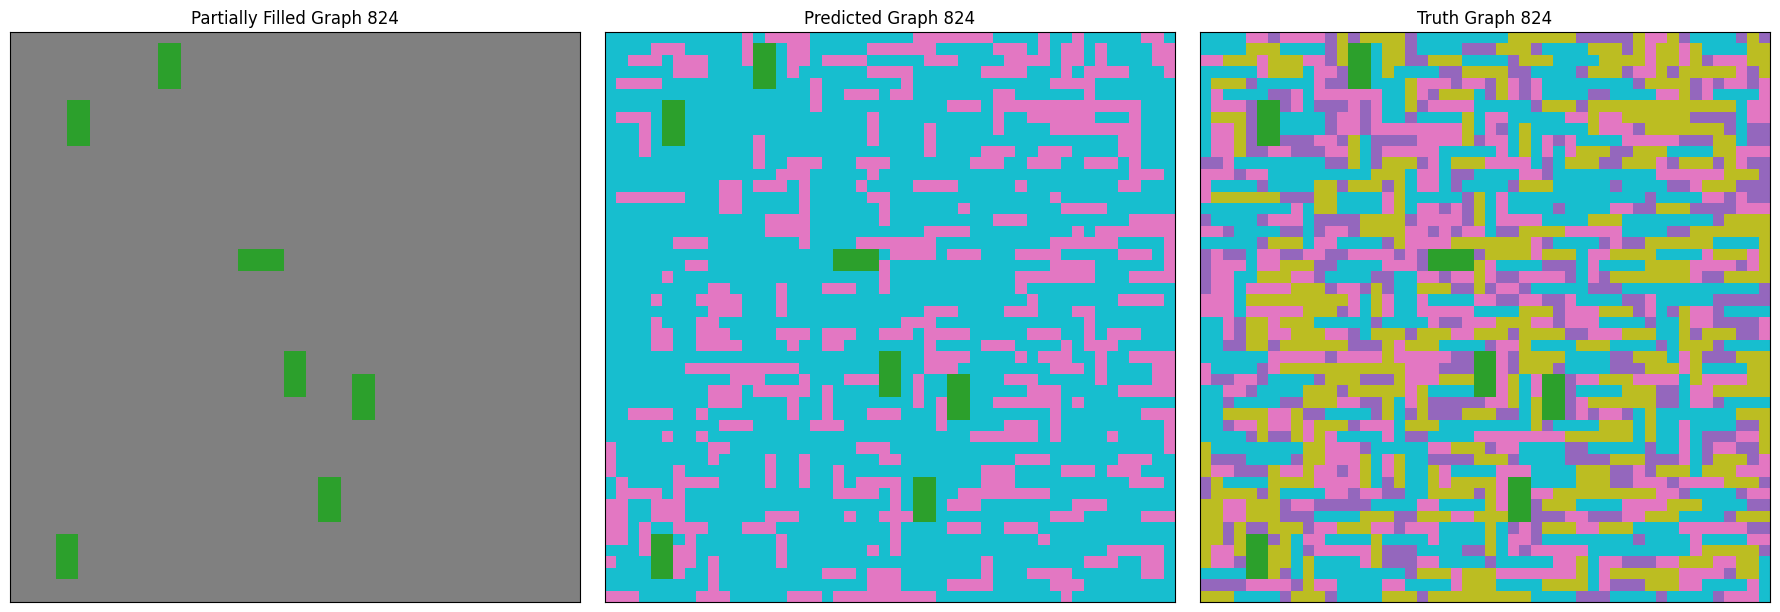

Visualization saved to /content/drive/MyDrive/Model Testing/0036/Graph_824/visualization_Graph_824.png

--- Sample Data for Partially Filled Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           0
1  0.020408    0.0           0
2  0.040816    0.0           0
3  0.061224    0.0           0
4  0.081633    0.0           0

--- Sample Predicted Data ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           5
1  0.020408    0.0           3
2  0.040816    0.0           3
3  0.061224    0.0           3
4  0.081633    0.0           3

--- Sample Data for Ground Truth Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           2
1  0.020408    0.0           1
2  0.040816    0.0           1
3  0.061224    0.0           1
4  0.081633    0.0           1


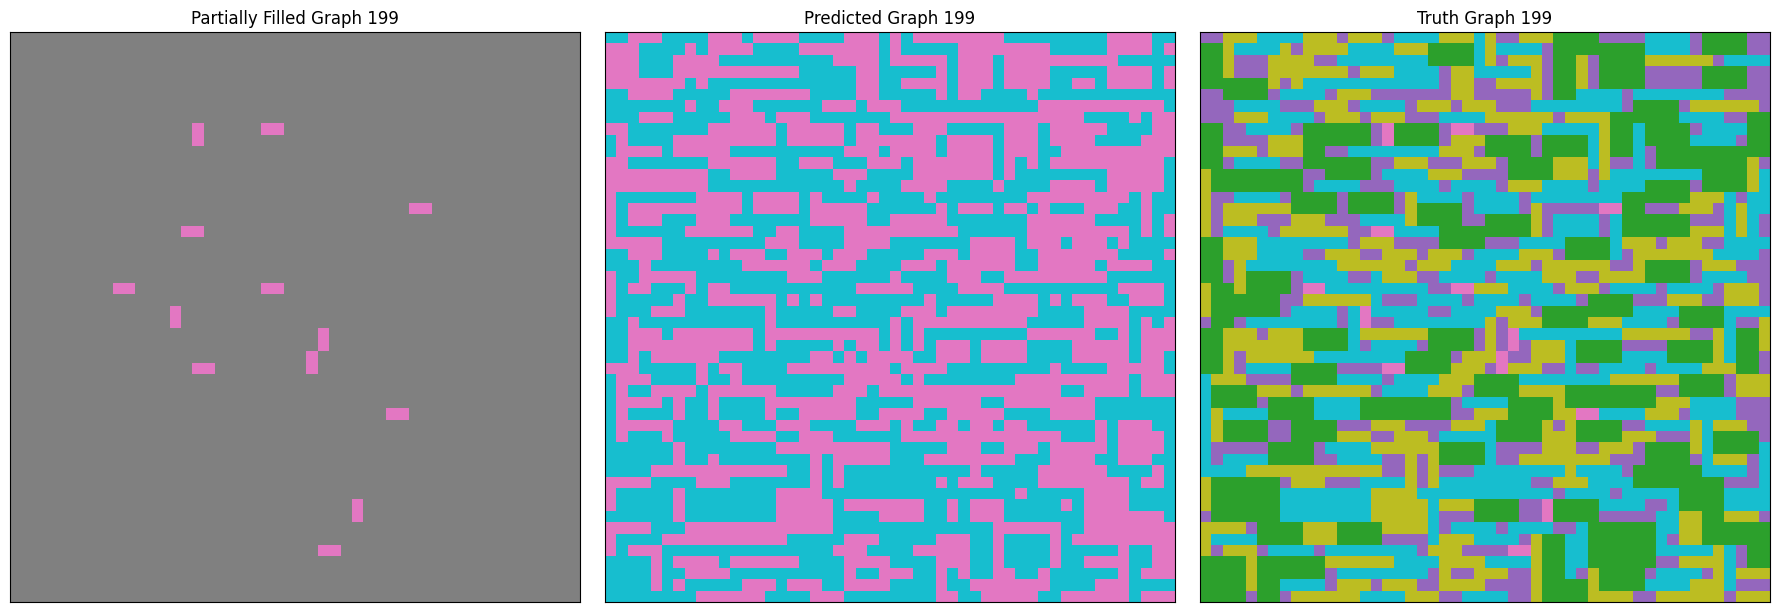

Visualization saved to /content/drive/MyDrive/Model Testing/0036/Graph_199/visualization_Graph_199.png

--- Sample Data for Partially Filled Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           0
1  0.020408    0.0           0
2  0.040816    0.0           0
3  0.061224    0.0           0
4  0.081633    0.0           0

--- Sample Predicted Data ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           5
1  0.020408    0.0           5
2  0.040816    0.0           5
3  0.061224    0.0           5
4  0.081633    0.0           3

--- Sample Data for Ground Truth Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           2
1  0.020408    0.0           3
2  0.040816    0.0           3
3  0.061224    0.0           2
4  0.081633    0.0           4


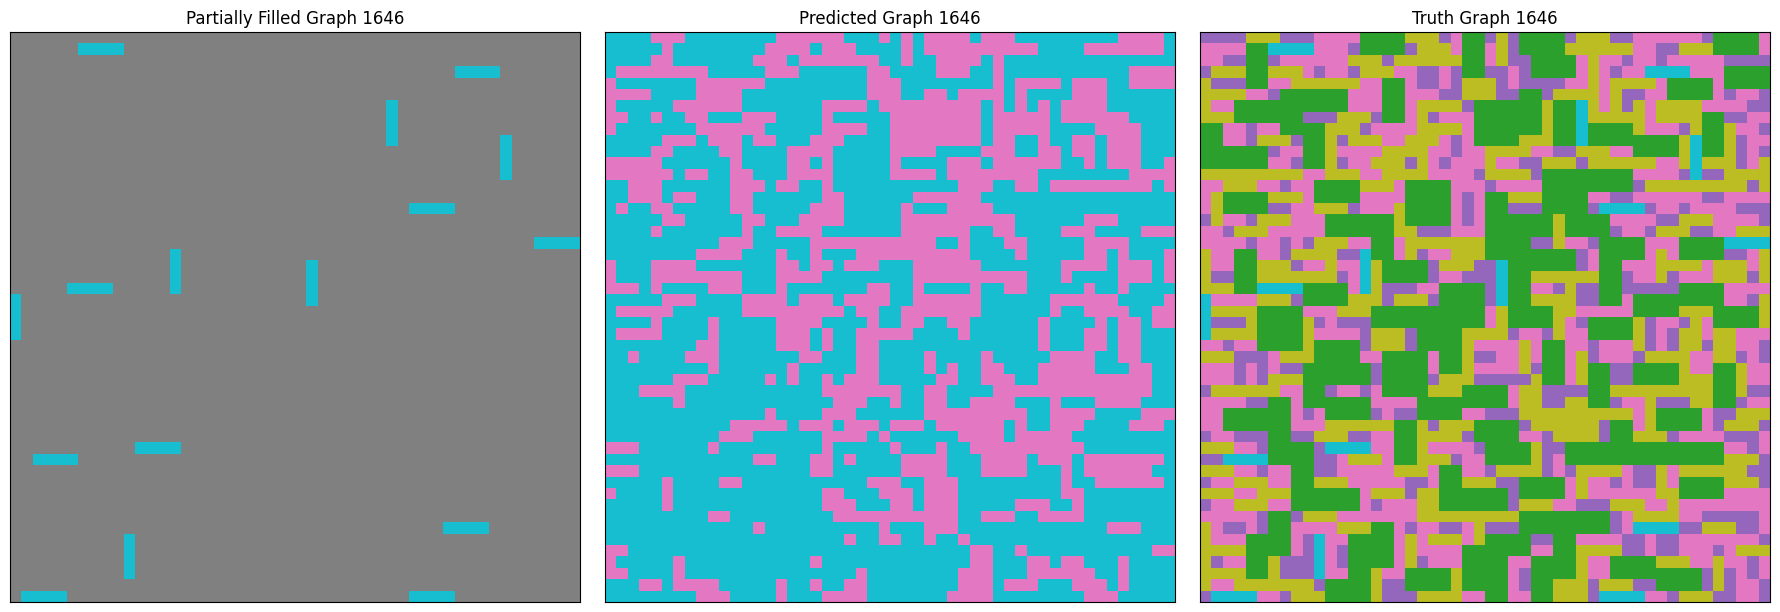

Visualization saved to /content/drive/MyDrive/Model Testing/0036/Graph_1646/visualization_Graph_1646.png

--- Sample Data for Partially Filled Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           0
1  0.020408    0.0           0
2  0.040816    0.0           0
3  0.061224    0.0           0
4  0.081633    0.0           0

--- Sample Predicted Data ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           5
1  0.020408    0.0           5
2  0.040816    0.0           5
3  0.061224    0.0           5
4  0.081633    0.0           3

--- Sample Data for Ground Truth Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           5
1  0.020408    0.0           5
2  0.040816    0.0           5
3  0.061224    0.0           2
4  0.081633    0.0           1


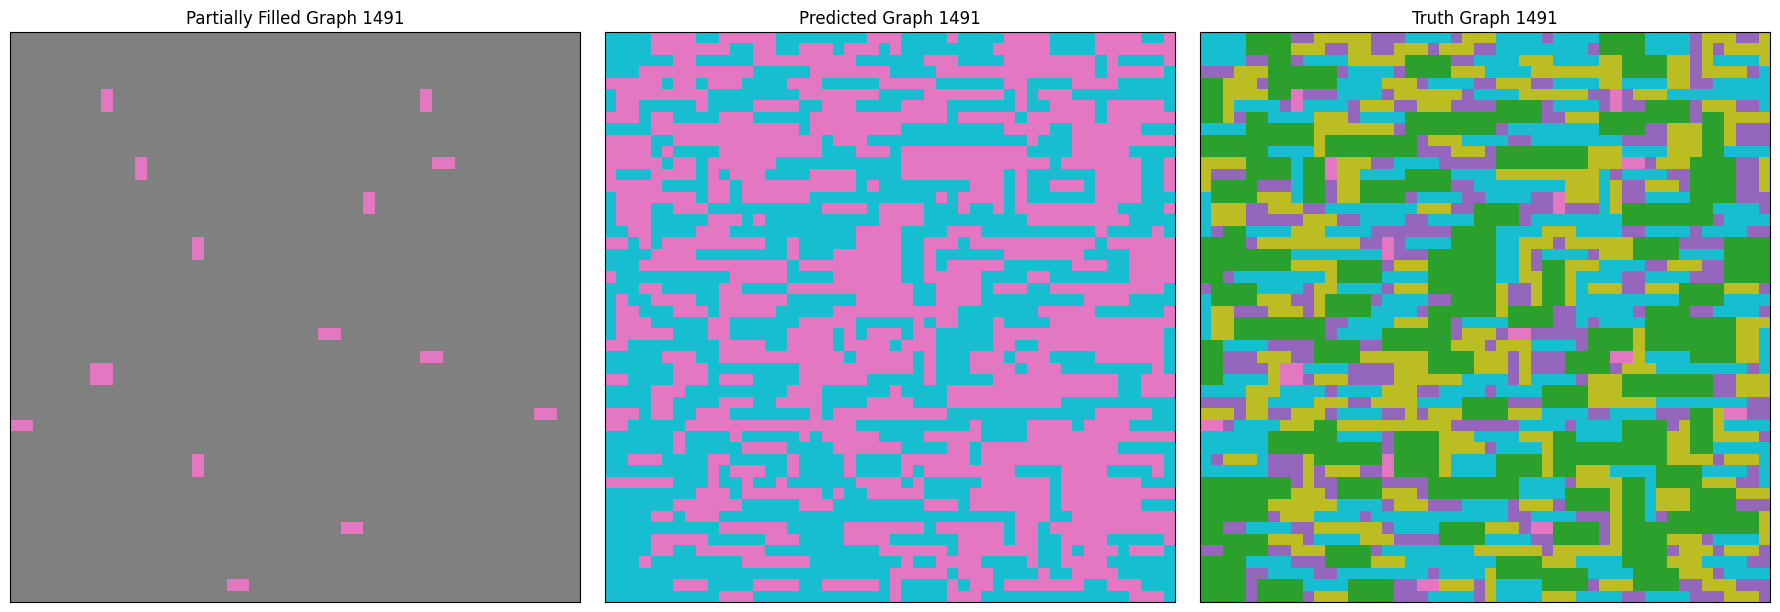

Visualization saved to /content/drive/MyDrive/Model Testing/0036/Graph_1491/visualization_Graph_1491.png

--- Sample Data for Partially Filled Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           0
1  0.020408    0.0           0
2  0.040816    0.0           0
3  0.061224    0.0           0
4  0.081633    0.0           0

--- Sample Predicted Data ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           3
1  0.020408    0.0           5
2  0.040816    0.0           5
3  0.061224    0.0           5
4  0.081633    0.0           5

--- Sample Data for Ground Truth Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           4
1  0.020408    0.0           2
2  0.040816    0.0           5
3  0.061224    0.0           5
4  0.081633    0.0           5


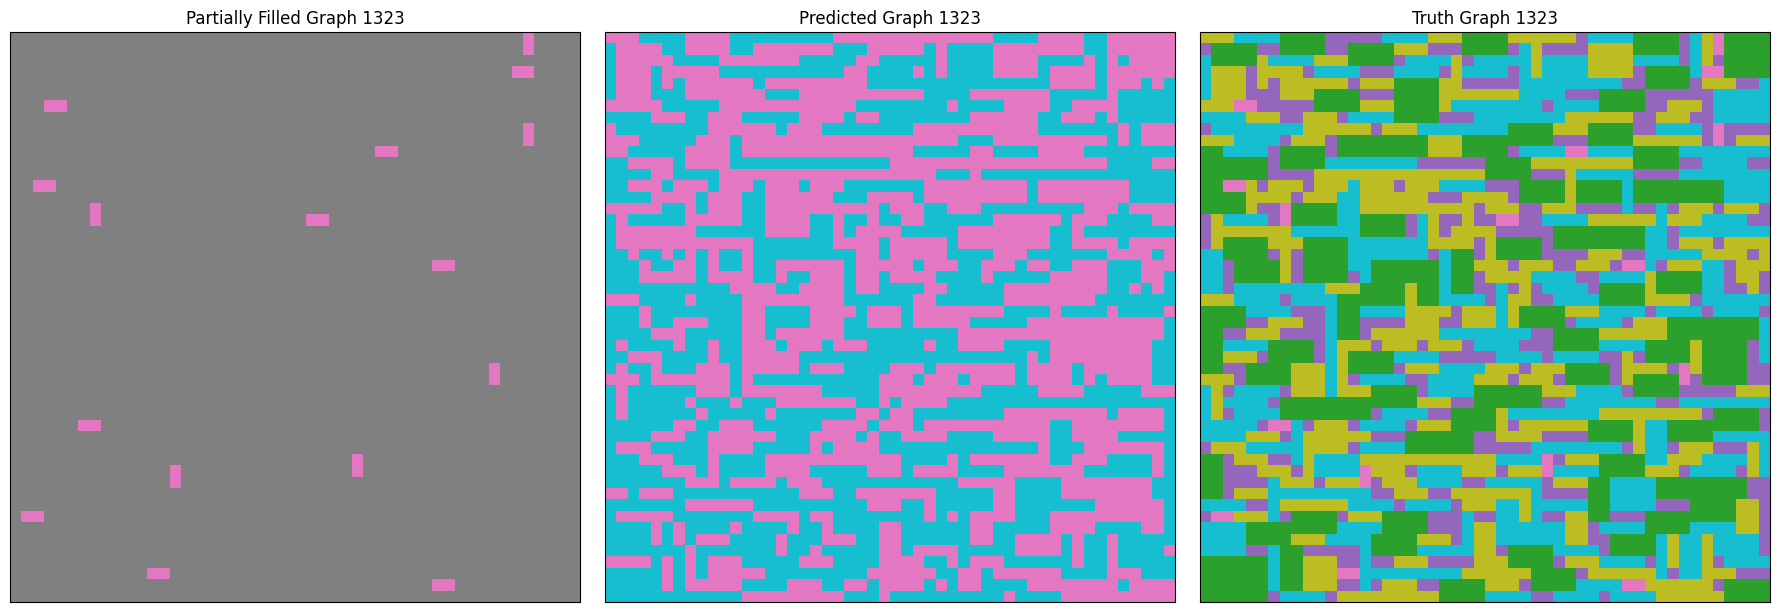

Visualization saved to /content/drive/MyDrive/Model Testing/0036/Graph_1323/visualization_Graph_1323.png

--- Sample Data for Partially Filled Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           0
1  0.020408    0.0           0
2  0.040816    0.0           0
3  0.061224    0.0           0
4  0.081633    0.0           0

--- Sample Predicted Data ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           5
1  0.020408    0.0           3
2  0.040816    0.0           3
3  0.061224    0.0           3
4  0.081633    0.0           3

--- Sample Data for Ground Truth Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           5
1  0.020408    0.0           1
2  0.040816    0.0           1
3  0.061224    0.0           4
4  0.081633    0.0           4


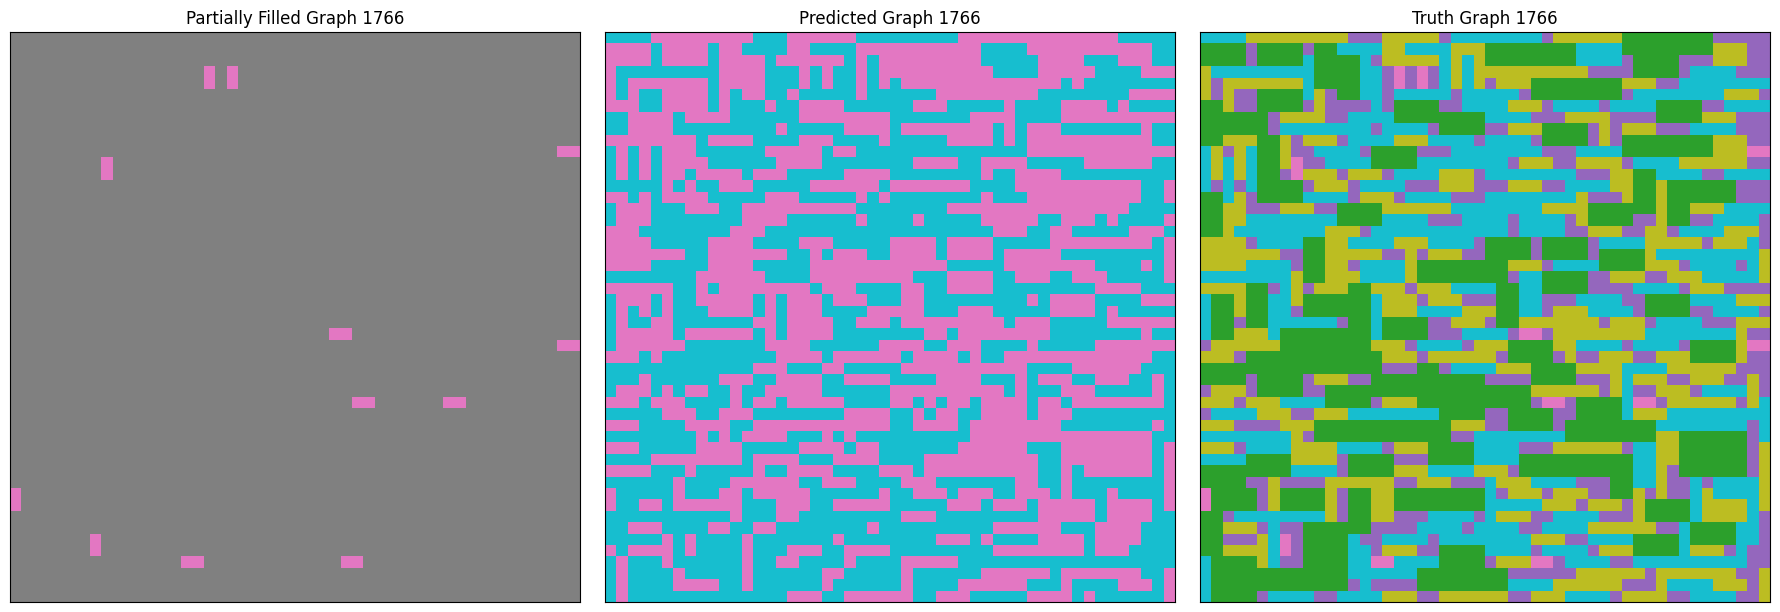

Visualization saved to /content/drive/MyDrive/Model Testing/0036/Graph_1766/visualization_Graph_1766.png

--- Sample Data for Partially Filled Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           0
1  0.020408    0.0           0
2  0.040816    0.0           0
3  0.061224    0.0           0
4  0.081633    0.0           0

--- Sample Predicted Data ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           3
1  0.020408    0.0           3
2  0.040816    0.0           3
3  0.061224    0.0           3
4  0.081633    0.0           5

--- Sample Data for Ground Truth Graph ---
      x_pos  y_pos  brick_type
0  0.000000    0.0           1
1  0.020408    0.0           1
2  0.040816    0.0           1
3  0.061224    0.0           1
4  0.081633    0.0           1


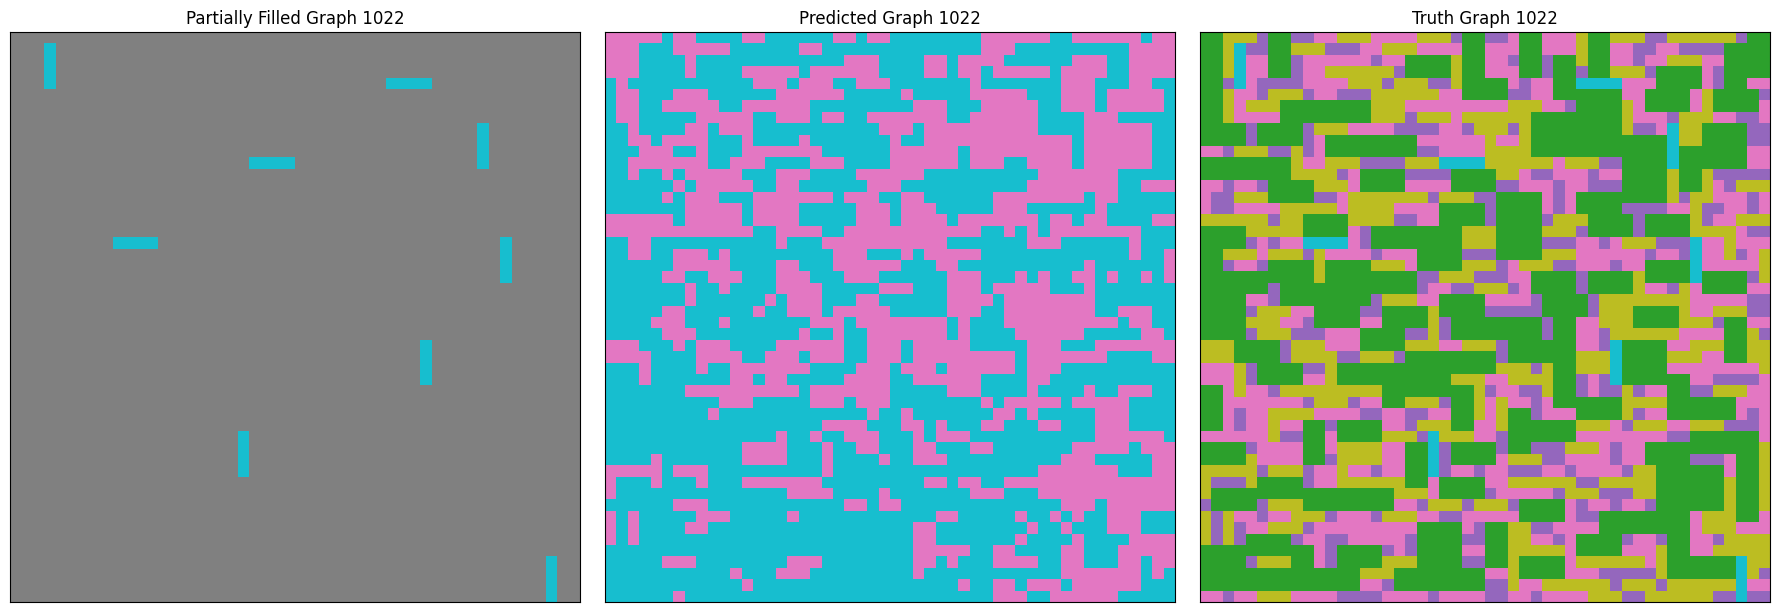

Visualization saved to /content/drive/MyDrive/Model Testing/0036/Graph_1022/visualization_Graph_1022.png


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# Helper function to convert one-hot encoded brick_type to scalar label (1-5)
def one_hot_to_label(one_hot_array):
    return np.argmax(one_hot_array) + 1

# Create a DataFrame with scalar labels for brick_type (from one-hot encoded)
def create_simple_graph_df(node_features_df):
    """
    Create a simplified DataFrame with x_pos, y_pos, and scalar brick_type (1-5) from one-hot encoded values.
    """
    simple_df = node_features_df[['x_pos', 'y_pos']].copy()
    simple_df['brick_type'] = node_features_df['brick_type'].apply(one_hot_to_label)
    return simple_df

# Helper function to create a subfolder for each graph
def create_graph_subfolder(parent_dir, graph_id):
    graph_folder = os.path.join(parent_dir, f"Graph_{graph_id}")
    os.makedirs(graph_folder, exist_ok=True)
    return graph_folder

# Helper function to plot the grid
def plot_graph(grid_df, title="Graph", ax=None, grid_size=50):
    grid = np.zeros((grid_size, grid_size))
    for i, row in grid_df.iterrows():
        x, y = int(row['x_pos'] * grid_size), int(row['y_pos'] * grid_size)
        grid[x, y] = row['brick_type']  # Set brick_type for grid

    # Define colors for brick types and grey for unlabelled nodes (brick_type = 0)
    cmap = plt.get_cmap('tab10', 6)  # 6 colors for brick types (including background)
    cmap.set_under('grey')  # Grey color for 'brick_type' 0 (unlabeled nodes)

    ax.imshow(grid, cmap=cmap, vmin=0.1, vmax=5)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Function to visualize predictions vs truth and save to the graph-specific subfolder
def visualize_predictions_vs_truth(pattern_dgl_graph, pattern_node_features_df, graph_id, base_dir):
    # Create a subfolder for this graph within the base directory
    graph_folder = create_graph_subfolder(base_dir, graph_id)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # **Step 1: Create the Partially Filled Graph**
    partially_filled_df = pattern_node_features_df.copy(deep=True)
    partially_filled_df['brick_type'] = partially_filled_df.apply(
        lambda row: one_hot_to_label(row['brick_type']) if row['primary_brick'] == 1 else 0, axis=1
    )  # Set non-primary brick nodes to 0
    print("\n--- Sample Data for Partially Filled Graph ---")
    print(partially_filled_df[['x_pos', 'y_pos', 'brick_type']].head())
    plot_graph(partially_filled_df, title=f"Partially Filled Graph {graph_id}", ax=axes[0])

    # **Step 2: Predict brick types using the trained model**
    model.eval()
    with torch.no_grad():
        node_feats = pattern_dgl_graph.ndata['features'].clone().detach()
        predictions = model(pattern_dgl_graph, node_feats).argmax(dim=1).numpy()

    # **Step 3: Create the Predicted Graph**
    predicted_df = partially_filled_df.copy(deep=True)
    predicted_df['brick_type'] = predicted_df.apply(
        lambda row, pred=predictions: pred[row.name] if row['brick_type'] == 0 else row['brick_type'], axis=1
    )  # Apply predictions for non-primary bricks
    print("\n--- Sample Predicted Data ---")
    print(predicted_df[['x_pos', 'y_pos', 'brick_type']].head())
    plot_graph(predicted_df, title=f"Predicted Graph {graph_id}", ax=axes[1])

    # **Step 4: Plot the Ground Truth Graph (fully labeled pattern)**
    ground_truth_df = create_simple_graph_df(pattern_node_features_df)
    print("\n--- Sample Data for Ground Truth Graph ---")
    print(ground_truth_df.head())
    plot_graph(ground_truth_df, title=f"Truth Graph {graph_id}", ax=axes[2])

    # Save the visualizations in the graph-specific folder
    plot_filename = os.path.join(graph_folder, f"visualization_Graph_{graph_id}.png")
    plt.tight_layout()
    plt.savefig(plot_filename)
    plt.show()

    print(f"Visualization saved to {plot_filename}")

# Randomly pick three test graphs for visualization
random_test_graphs = np.random.choice(test_patterns, size=10, replace=False)

# Visualize the three random test graphs and save them to subfolders
for graph_id in random_test_graphs:
    visualize_predictions_vs_truth(
        all_pattern_dgl_graphs[graph_id],      # Full pattern DGL graph
        combined_node_features[graph_id],      # Node features of the full pattern
        graph_id,                              # The current graph's ID
        save_directory_4_6                     # Parent directory created in Step 4.6
    )



In [ ]:
import pandas as pd
from IPython.display import display, HTML

# Assuming you have 10 test graphs selected and each has 2500 nodes
# Generate 10 different prediction sets from 10 test graphs
# The predictions are stored in lists predictions_1 to predictions_10
node_ids = list(range(2500))

# Generate predictions for 10 different test graphs
predictions = []
for i in range(10):
    preds = model(all_pattern_dgl_graphs[random_test_graphs[i]], all_pattern_dgl_graphs[random_test_graphs[i]].ndata['features']).argmax(dim=1).numpy()
    predictions.append(preds)

# Create a DataFrame with node IDs and the 10 sets of predictions
df = pd.DataFrame({
    'Node ID': node_ids,
    'Prediction Set 1': predictions[0],
    'Prediction Set 2': predictions[1],
    'Prediction Set 3': predictions[2],
    'Prediction Set 4': predictions[3],
    'Prediction Set 5': predictions[4],
    'Prediction Set 6': predictions[5],
    'Prediction Set 7': predictions[6],
    'Prediction Set 8': predictions[7],
    'Prediction Set 9': predictions[8],
    'Prediction Set 10': predictions[9]
})

# Convert the DataFrame to an HTML table with scrollable formatting
display(HTML(df.to_html(index=False)))


Node ID,Prediction Set 1,Prediction Set 2,Prediction Set 3,Prediction Set 4,Prediction Set 5,Prediction Set 6,Prediction Set 7,Prediction Set 8,Prediction Set 9,Prediction Set 10
0,5,5,5,5,5,5,5,3,5,3
1,3,5,5,5,3,5,5,5,3,3
2,3,3,5,5,3,5,5,5,3,3
3,3,3,5,5,3,5,5,5,3,3
4,3,3,5,5,3,3,3,5,3,5
5,5,3,5,5,5,3,5,5,3,5
6,3,3,5,5,5,3,5,3,3,5
7,5,3,5,5,5,3,3,5,5,5
8,5,5,5,5,3,3,5,3,5,5
9,5,3,5,5,5,5,3,3,3,5
